In [1]:
month = 'Full'  # Change this to any month name you want

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import os
import json
import re
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder

# Optional: Fix random seed
SEED = 42


In [2]:
print("\u2728 Using TOP_50_FEATURES from univariate selection...")
from enhanced_univariate_temporal_results.selected_features import TOP_50_FEATURES

# Remove known leaky features
excluded_features = ["Contract Law Type (Broad)", "Law Type Frequency", "Inquiry Call Type Law Type (Narrow)", "Shared Law Type", "Inquiry Call Type Law Type (Broad)", "Law Type", "Law_Type_Qual_Rate", "Law Type Qual", "Is_MVA_Case", "DNIS", "Inquiry_Call_Type_Law_Type_Broad", "Inquiry_Call_Type_Law_Type_Broad__MVA", "Inquiry_Call_Type_Law_Type_Broad_MVA"]
TOP_50_FEATURES = [f for f in TOP_50_FEATURES if f not in excluded_features]

# Load dataset and prepare target
TARGET_VARIABLE = "MVA_Qualified"
df = pd.read_csv("enhanced_engineered_data/dataset_with_temporal_features.csv")

# 🔍 Month filtering
if month != "Full":
    # Convert month name/number to numeric (Jan=1, ..., Dec=12)
    month_map = {
        "January": 1, "February": 2, "March": 3, "April": 4,
        "May": 5, "June": 6, "July": 7, "August": 8,
        "September": 9, "October": 10, "November": 11, "December": 12
    }
    # Accept both names ("May") and numeric strings ("5")
    month_num = month_map.get(month, None)
    if month_num is None:
        try:
            month_num = int(month)
        except ValueError:
            raise ValueError(f"Invalid month value: {month}")

    df = df[df["Call_Start_Date_Month"] == month_num]
    print(f"📅 Filtering dataset for month = {month} ({month_num}) → {df.shape}")

else:
    print("📅 Using full dataset (all months)")


X = df[TOP_50_FEATURES].copy()
y = df[TARGET_VARIABLE]

# One-hot encode categorical features
categorical_cols = X.select_dtypes(include='object').columns.tolist()
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Remove duplicated columns
dupes = X_encoded.columns[X_encoded.columns.duplicated()].tolist()
if dupes:
    print(f"⚠️ Duplicate column names found: {dupes}")
    X_encoded = X_encoded.loc[:, ~X_encoded.columns.duplicated()]

# Apply VarianceThreshold
vt = VarianceThreshold(threshold=0.01)
X_encoded = pd.DataFrame(vt.fit_transform(X_encoded), columns=X_encoded.columns[vt.get_support(indices=True)])

# Sanitize column names
def sanitize_column(col):
    return re.sub(r"[^\w\d_]+", "_", col)

X_encoded.columns = [sanitize_column(col) for col in X_encoded.columns]

# === 🔍 Correlation filtering ===
corr_matrix = X_encoded.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [column for column in upper.columns if any(upper[column] > 0.9)]

if high_corr:
    print(f"🧹 Removing {len(high_corr)} highly correlated features:\n", high_corr)
    X_encoded = X_encoded.drop(columns=high_corr)


# Train/test split
X_train, X_val, y_train, y_val = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=SEED
)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")



✨ Using TOP_50_FEATURES from univariate selection...
📅 Using full dataset (all months)
⚠️ Duplicate column names found: ['Incident_Recency_Detailed_Old', 'Incident_Recency_Detailed_Unknown']
🧹 Removing 11 highly correlated features:
 ['Delayed_Treatment_Risk', 'Incident_Within_730_Days', 'Incident_Within_365_Days', 'Incident_to_Call_Within_30d', 'Incident_to_Call_Within_14d', 'Incident_to_Call_Within_7d', 'Days_Incident_to_Call', 'Log_Days_Since_Incident', 'Incident_Recency_Detailed_Very_Recent', 'Incident_Season_Summer', 'Incident_Season_Unknown']
Train shape: (399, 19), Validation shape: (100, 19)


c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_variance_threshold.py:114: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


In [3]:
print("\U0001F4AA Training LightGBM model...")
model = lgb.LGBMClassifier(
    objective="binary",
    random_state=SEED,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Evaluation
y_pred_proba = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(X_val)
auc = roc_auc_score(y_val, y_pred_proba)
print(f"\n\U0001F947 Validation AUC: {auc:.4f}\n")
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

💪 Training LightGBM model...
[LightGBM] [Info] Number of positive: 24, number of negative: 375
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39
[LightGBM] [Info] Number of data points in the train set: 399, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.060150 -> initscore=-2.748872
[LightGBM] [Info] Start training from score -2.748872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [4]:
print("\U0001F4CB Running cross-validation AUC scoring...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
cv_scores = cross_val_score(model, X_encoded, y, cv=skf, scoring='roc_auc')
print(f"CV AUC scores: {cv_scores}")
print(f"Mean CV AUC: {np.mean(cv_scores):.4f} \u00b1 {np.std(cv_scores):.4f}")

📋 Running cross-validation AUC scoring...
[LightGBM] [Info] Number of positive: 24, number of negative: 375
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34
[LightGBM] [Info] Number of data points in the train set: 399, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.060150 -> initscore=-2.748872
[LightGBM] [Info] Start training from score -2.748872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

📊 Calculating SHAP values...


c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


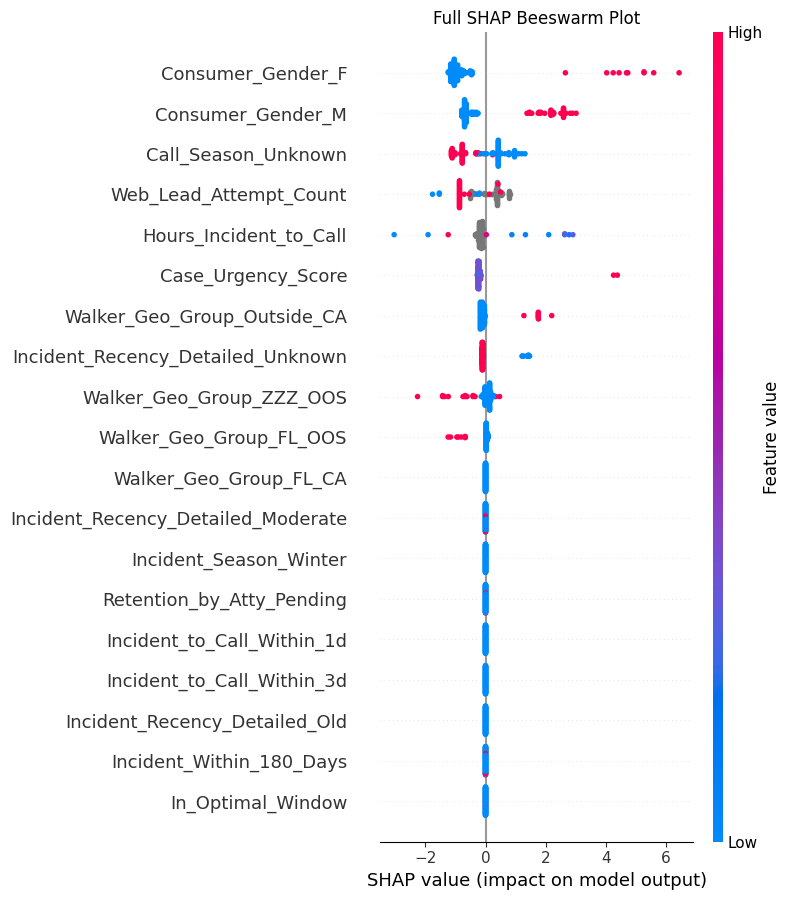

In [5]:
import numpy as np
if not hasattr(np, "bool"):
    np.bool = np.bool_   # Patch for SHAP

print("📊 Calculating SHAP values...")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

plt.figure()
shap.summary_plot(shap_values, X_val, max_display=30, show=False)

# Set title on the correct axes
ax = plt.gca()
ax.set_title(f"{month} SHAP Beeswarm Plot")

plt.tight_layout()

# ✅ Ensure directory exists
os.makedirs("multivariate_modeling_results/shap", exist_ok=True)
plt.savefig(f"multivariate_modeling_results/shap/{month}_SHAP_Summary_Plot.png", dpi=150)


In [6]:
print("💾 Saving final multivariate results...")

# Ensure directory exists
os.makedirs("multivariate_modeling_results", exist_ok=True)

# Save model
import joblib
joblib.dump(model, "multivariate_modeling_results/final_model.pkl")

# Save feature list
with open("multivariate_modeling_results/multivariate_selected_features.py", "w") as f:
    f.write("TOP_MULTIVARIATE_FEATURES = " + repr(list(X_encoded.columns)) + "\n")
    f.write("TARGET_VARIABLE = 'MVA_Qualified'\n")


# Save cross-validation results
cv_result = {
    "cv_auc_scores": list(cv_scores),
    "cv_auc_mean": float(np.mean(cv_scores)),
    "cv_auc_std": float(np.std(cv_scores))
}
with open("multivariate_modeling_results/cv_results.json", "w") as f:
    json.dump(cv_result, f, indent=2)


print("✅ Model, selected features, and cross-validation results saved to multivariate_modeling_results/")


💾 Saving final multivariate results...
✅ Model, selected features, and cross-validation results saved to multivariate_modeling_results/


In [7]:
# --- Build shap_matrix (2D) from existing shap_values and pick the same X used for SHAP ---
import numpy as np,  pandas as pd

# Prefer validation set if present (matches your beeswarm)
X_for_shap = globals().get("X_val", globals().get("X"))

# Convert shap_values (which may be a list for binary/multiclass) to a 2D matrix
if isinstance(shap_values, list):
    # choose positive class if available; else index 1 as default
    try:
        pos_idx = list(getattr(model, "classes_", [])).index(1)
    except Exception:
        pos_idx = 1
    shap_matrix = shap_values[pos_idx]
else:
    shap_matrix = shap_values

shap_matrix = np.asarray(shap_matrix)
if shap_matrix.ndim == 3:  # (n_samples, n_classes, n_features)
    shap_matrix = shap_matrix[:, 1, :]

# Safety check: columns must match
assert X_for_shap is not None, "X_val or X not found."
assert shap_matrix.shape[1] == X_for_shap.shape[1], \
    f"SHAP features ({shap_matrix.shape[1]}) != X columns ({X_for_shap.shape[1]})"


# === Build S with matching columns, then export ===
from pathlib import Path

CWD = Path.cwd()
INSIGHTS_XLSX = (CWD / "Insights.xlsx").resolve()

# 1) Find a dataframe whose column count matches shap_matrix
candidates = [
    ("X_val", globals().get("X_val")),
    ("X", globals().get("X")),
    ("X_encoded", globals().get("X_encoded")),
    ("X_train", globals().get("X_train")),
]
X_for_shap = None
for name, df_candidate in candidates:
    if df_candidate is not None and hasattr(df_candidate, "shape"):
        if df_candidate.shape[1] == np.asarray(shap_matrix).shape[1]:
            X_for_shap = df_candidate
            print(f"[Info] Using columns from {name}")
            break

feature_names = None
if X_for_shap is not None:
    feature_names = list(X_for_shap.columns)
else:
    # Fallback to model feature names if available
    feat_names = None
    try:
        feat_names = model.booster_.feature_name()
    except Exception:
        feat_names = getattr(model, "feature_name_", None)
    if feat_names is not None and len(feat_names) == np.asarray(shap_matrix).shape[1]:
        feature_names = list(feat_names)
        print("[Info] Using feature names from model")
    else:
        feature_names = [f"f{i}" for i in range(np.asarray(shap_matrix).shape[1])]
        print("[Warn] Could not match a dataframe; using generic names")

# 2) Build S with the correct width/names
S = pd.DataFrame(np.asarray(shap_matrix), columns=feature_names)

# 3) Compute stats (mean_abs_shap = primary importance)
table = pd.DataFrame({
    "feature": feature_names,
    "rank_by_mean_abs_shap": np.argsort(-np.abs(S).mean(0)).argsort() + 1,
    "mean_abs_shap": np.abs(S).mean(0).values,
    "mean_shap": S.mean(0).values,
    "std_shap": S.std(0, ddof=1).values,
    "min_shap": S.min(0).values,
    "p25_shap": S.quantile(0.25, axis=0).values,
    "p50_shap": S.quantile(0.50, axis=0).values,
    "p75_shap": S.quantile(0.75, axis=0).values,
    "max_shap": S.max(0).values,
    "pct_positive_shap": (S > 0).mean(0).values,
    "n_rows": [S.shape[0]] * len(feature_names)
}).sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)

# Optional: add value stats if we found X_for_shap
if X_for_shap is not None:
    val_means, val_meds, val_stds, prevs = [], [], [], []
    for f in feature_names:
        if f in X_for_shap.columns:
            col = X_for_shap[f]
            if pd.api.types.is_numeric_dtype(col):
                val_means.append(col.mean()); val_meds.append(col.median()); val_stds.append(col.std(ddof=1)); prevs.append(np.nan)
            else:
                try: prevs.append((col == 1).mean())
                except Exception: prevs.append(np.nan)
                val_means.append(np.nan); val_meds.append(np.nan); val_stds.append(np.nan)
        else:
            val_means.append(np.nan); val_meds.append(np.nan); val_stds.append(np.nan); prevs.append(np.nan)
    table["feature_value_mean"] = val_means
    table["feature_value_median"] = val_meds
    table["feature_value_std"] = val_stds
    table["prevalence"] = prevs

# 4) Sheet name
try:
    MONTH_NAME = str(month)
except NameError:
    MONTH_NAME = CWD.parents[1].name

# 5) Write to Excel (overwrite sheet if exists)
INSIGHTS_XLSX.parent.mkdir(parents=True, exist_ok=True)
if INSIGHTS_XLSX.exists():
    with pd.ExcelWriter(INSIGHTS_XLSX, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
        table.to_excel(writer, sheet_name=MONTH_NAME, index=False)
else:
    with pd.ExcelWriter(INSIGHTS_XLSX, engine="openpyxl", mode="w") as writer:
        table.to_excel(writer, sheet_name=MONTH_NAME, index=False)

print(f"[Done] Wrote {len(table)} rows to '{INSIGHTS_XLSX}' (sheet: '{MONTH_NAME}')")


[Info] Using columns from X_val
[Done] Wrote 19 rows to 'E:\Work\Regressions\Multivariate\Full 2025\Marketing (QMVA)\For export\Insights.xlsx' (sheet: 'Full')


🔝 Using rank-based top features for Full: ['Consumer_Gender_F', 'Consumer_Gender_M', 'Call_Season_Unknown', 'Web_Lead_Attempt_Count', 'Hours_Incident_to_Call', 'Case_Urgency_Score', 'Walker_Geo_Group_Outside_CA', 'Incident_Recency_Detailed_Unknown', 'Walker_Geo_Group_ZZZ_OOS', 'Walker_Geo_Group_FL_OOS', 'Incident_to_Call_Within_1d', 'In_Optimal_Window', 'Incident_Season_Winter', 'Incident_Recency_Detailed_Old', 'Incident_to_Call_Within_3d', 'Incident_Within_180_Days', 'Walker_Geo_Group_FL_CA', 'Retention_by_Atty_Pending', 'Incident_Recency_Detailed_Moderate']
🔎 Top features for Full: ['Consumer_Gender_F', 'Consumer_Gender_M', 'Call_Season_Unknown', 'Web_Lead_Attempt_Count', 'Hours_Incident_to_Call', 'Case_Urgency_Score', 'Walker_Geo_Group_Outside_CA', 'Incident_Recency_Detailed_Unknown', 'Walker_Geo_Group_ZZZ_OOS', 'Walker_Geo_Group_FL_OOS', 'Incident_to_Call_Within_1d', 'In_Optimal_Window', 'Incident_Season_Winter', 'Incident_Recency_Detailed_Old', 'Incident_to_Call_Within_3d', 'Incid

c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


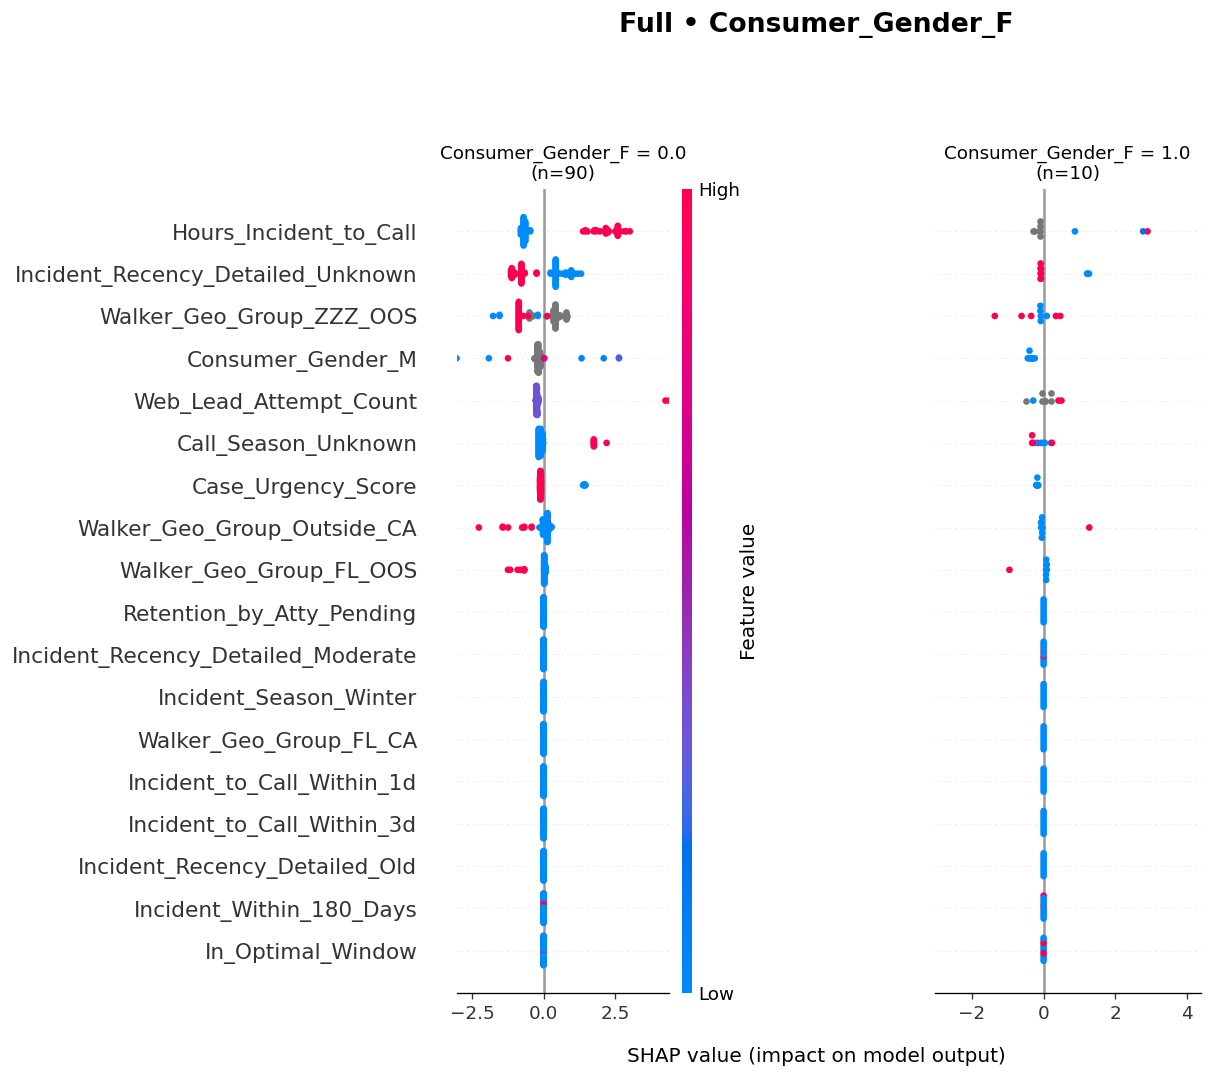

✅ Saved side-by-side figure (anchor excluded): multivariate_modeling_results\shap_zoom\Full\Full_Consumer_Gender_F_ALL_BUCKETS_side_by_side.png


c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


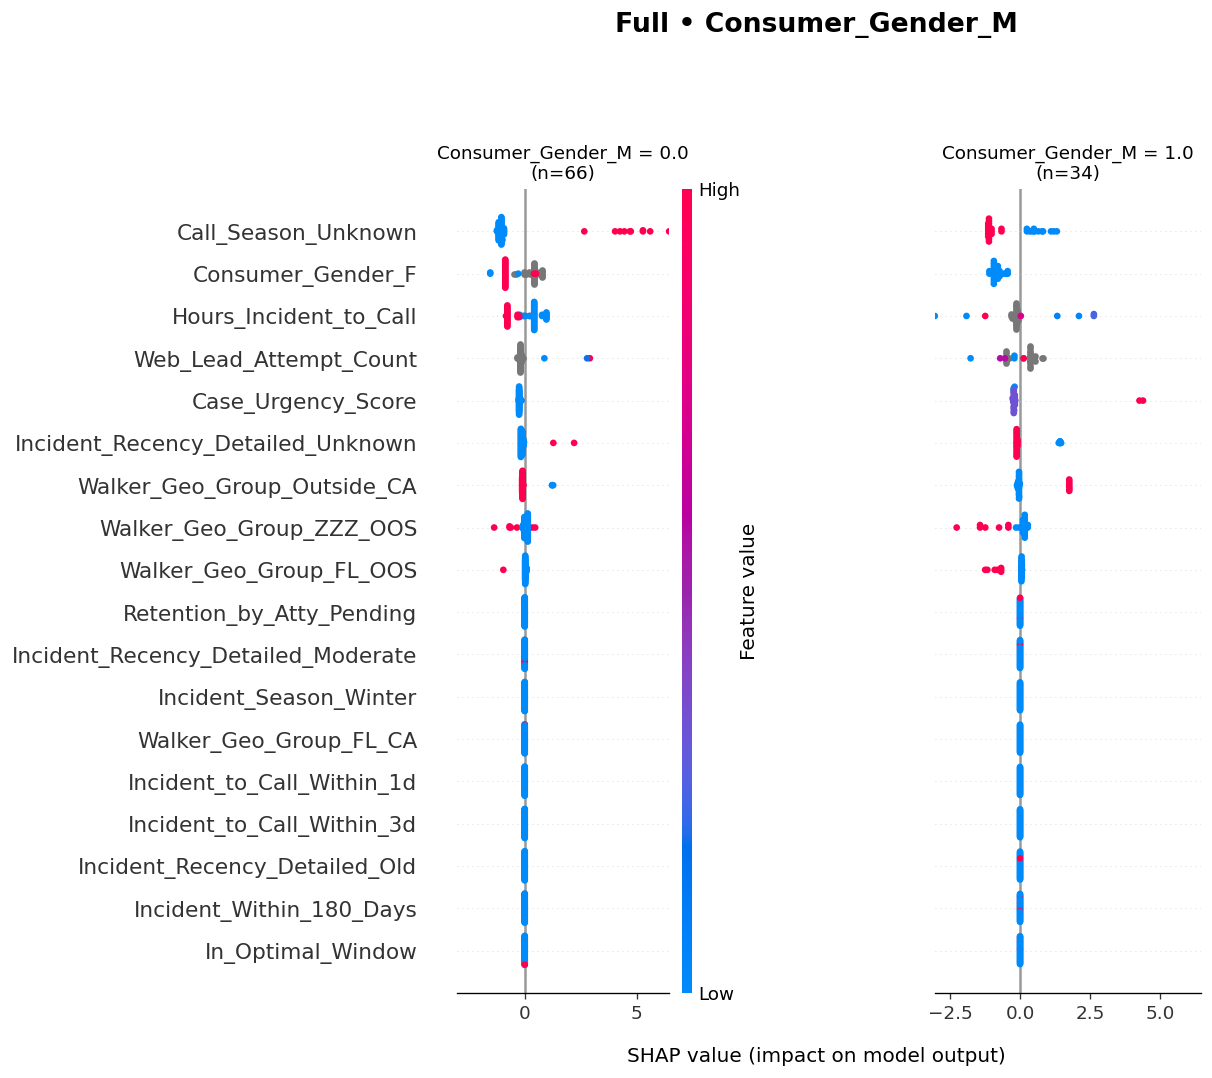

✅ Saved side-by-side figure (anchor excluded): multivariate_modeling_results\shap_zoom\Full\Full_Consumer_Gender_M_ALL_BUCKETS_side_by_side.png


c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning:

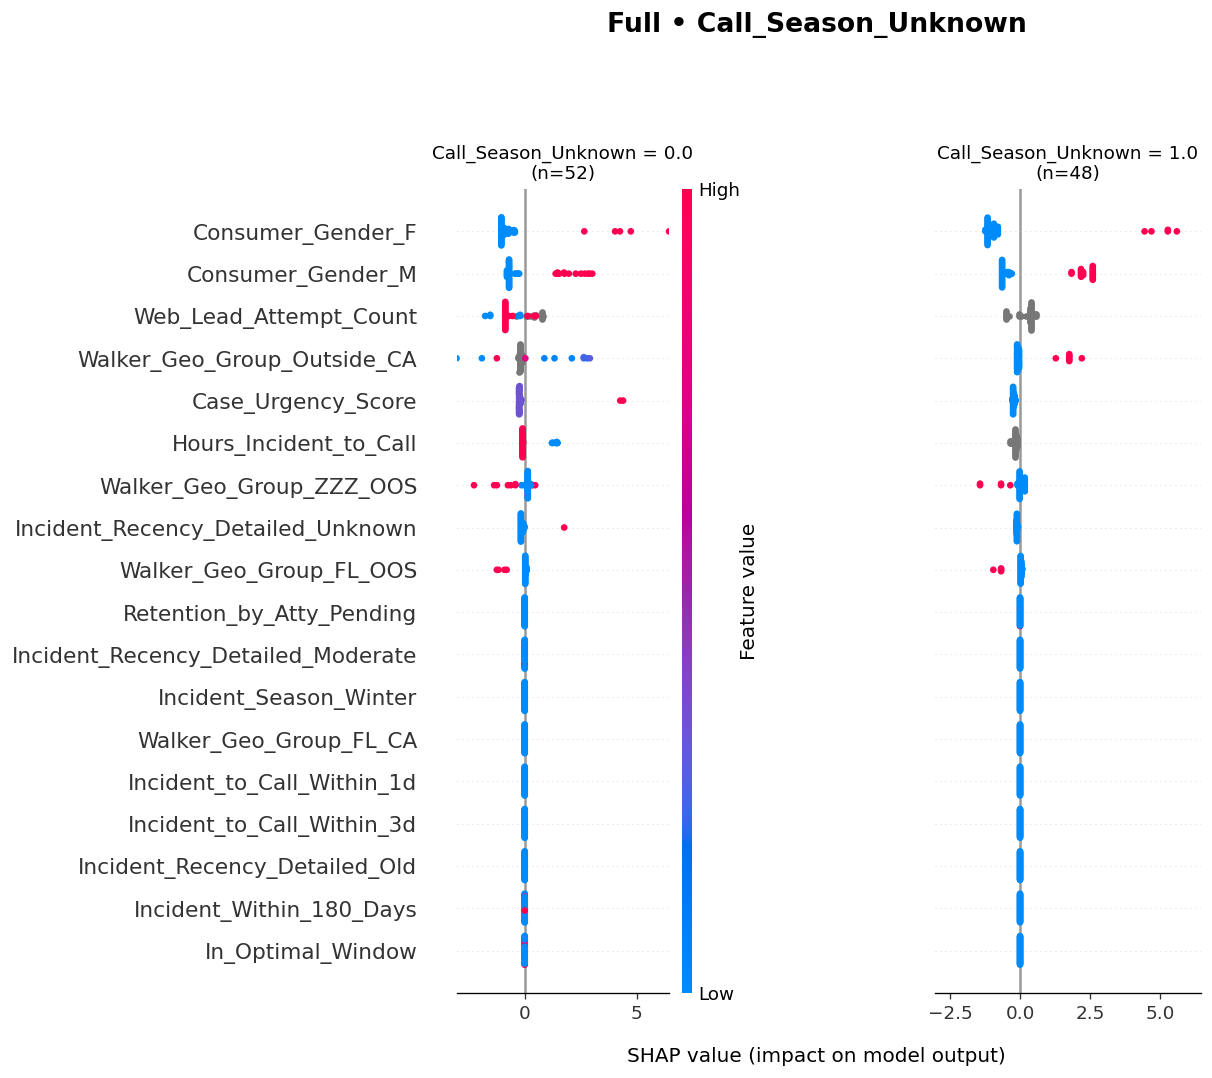

✅ Saved side-by-side figure (anchor excluded): multivariate_modeling_results\shap_zoom\Full\Full_Call_Season_Unknown_ALL_BUCKETS_side_by_side.png
⚠️ Skipping slice 'Web_Lead_Attempt_Count = nan' for Web_Lead_Attempt_Count: n=0 < 5
⚠️ Skipping slice 'Web_Lead_Attempt_Count = 3.0' for Web_Lead_Attempt_Count: n=1 < 5


c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


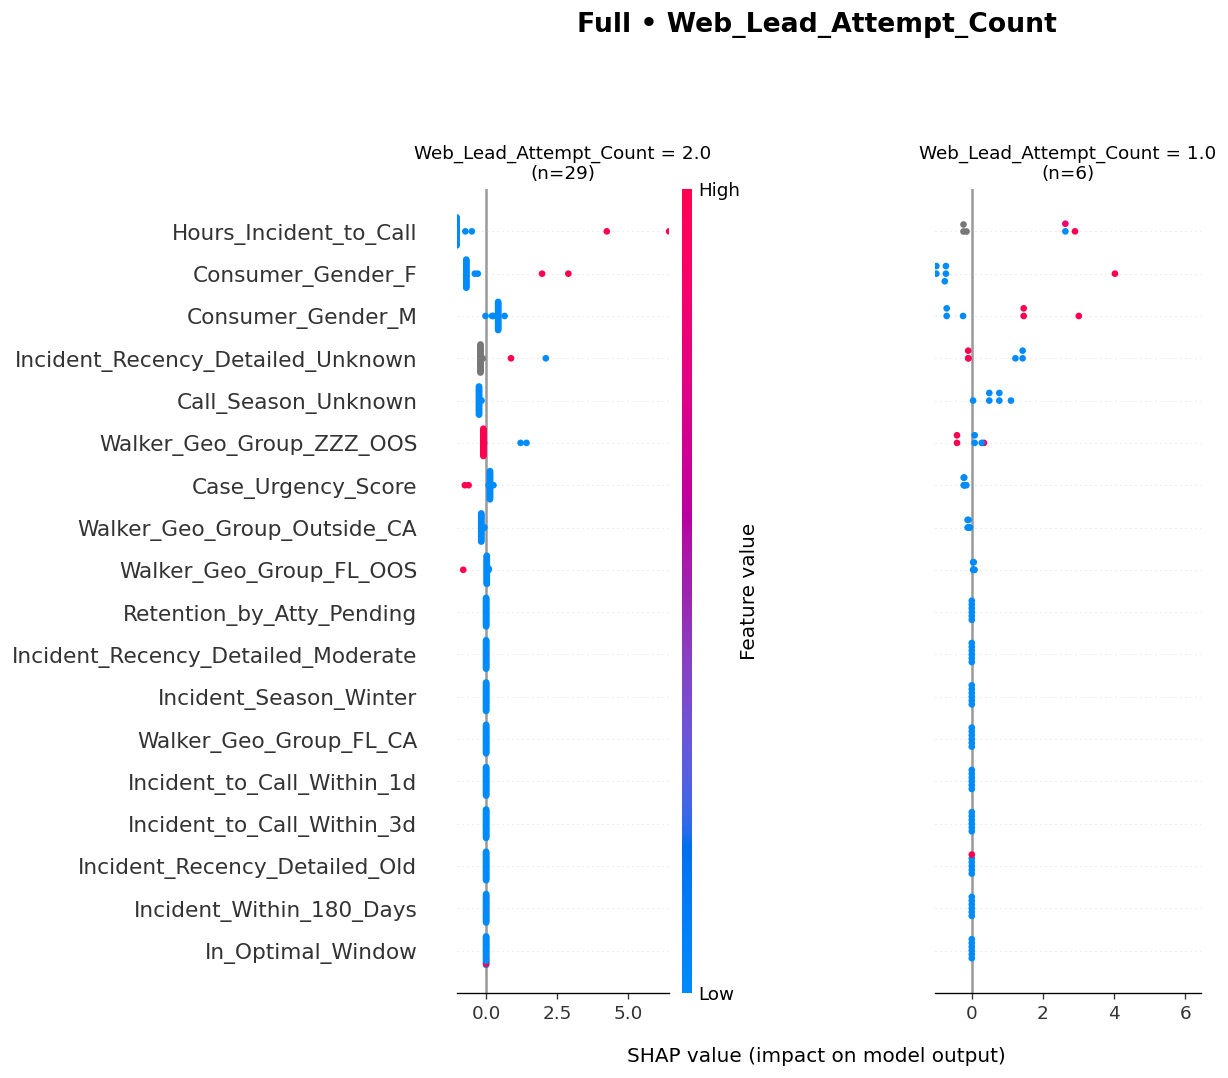

✅ Saved side-by-side figure (anchor excluded): multivariate_modeling_results\shap_zoom\Full\Full_Web_Lead_Attempt_Count_ALL_BUCKETS_side_by_side.png
⚠️ Skipping slice '2640 hours to 8840' for Hours_Incident_to_Call: n=2 < 5
⚠️ Skipping slice '8840 hours to 39168' for Hours_Incident_to_Call: n=4 < 5
⚠️ Skipping slice '39168 hours+' for Hours_Incident_to_Call: n=0 < 5


c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


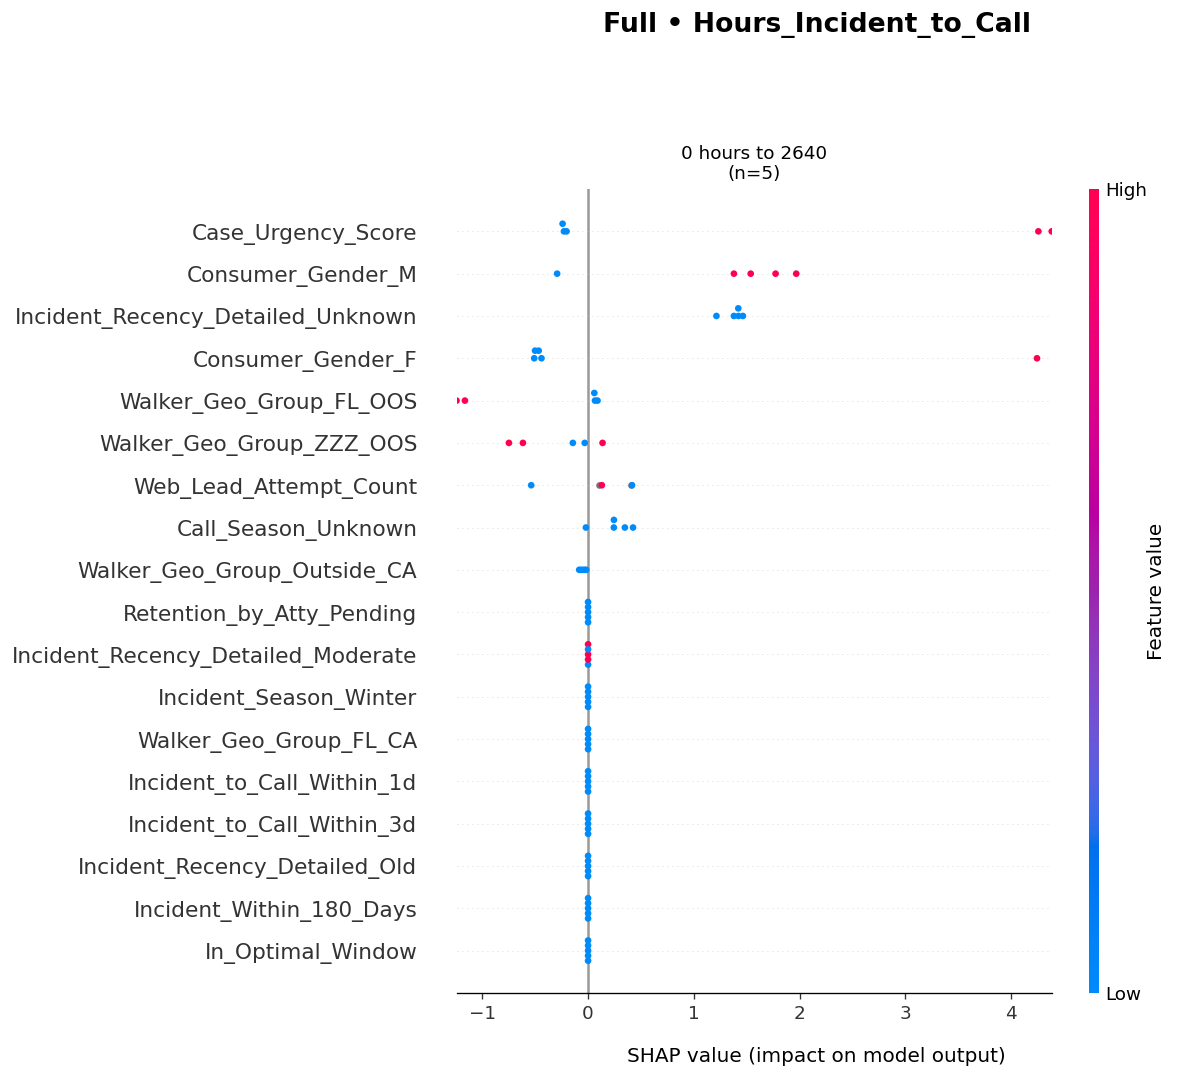

✅ Saved side-by-side figure (anchor excluded): multivariate_modeling_results\shap_zoom\Full\Full_Hours_Incident_to_Call_ALL_BUCKETS_side_by_side.png
⚠️ Skipping slice 'Case_Urgency_Score = 2.0' for Case_Urgency_Score: n=2 < 5
⚠️ Skipping slice 'Case_Urgency_Score = -1.0' for Case_Urgency_Score: n=2 < 5


c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


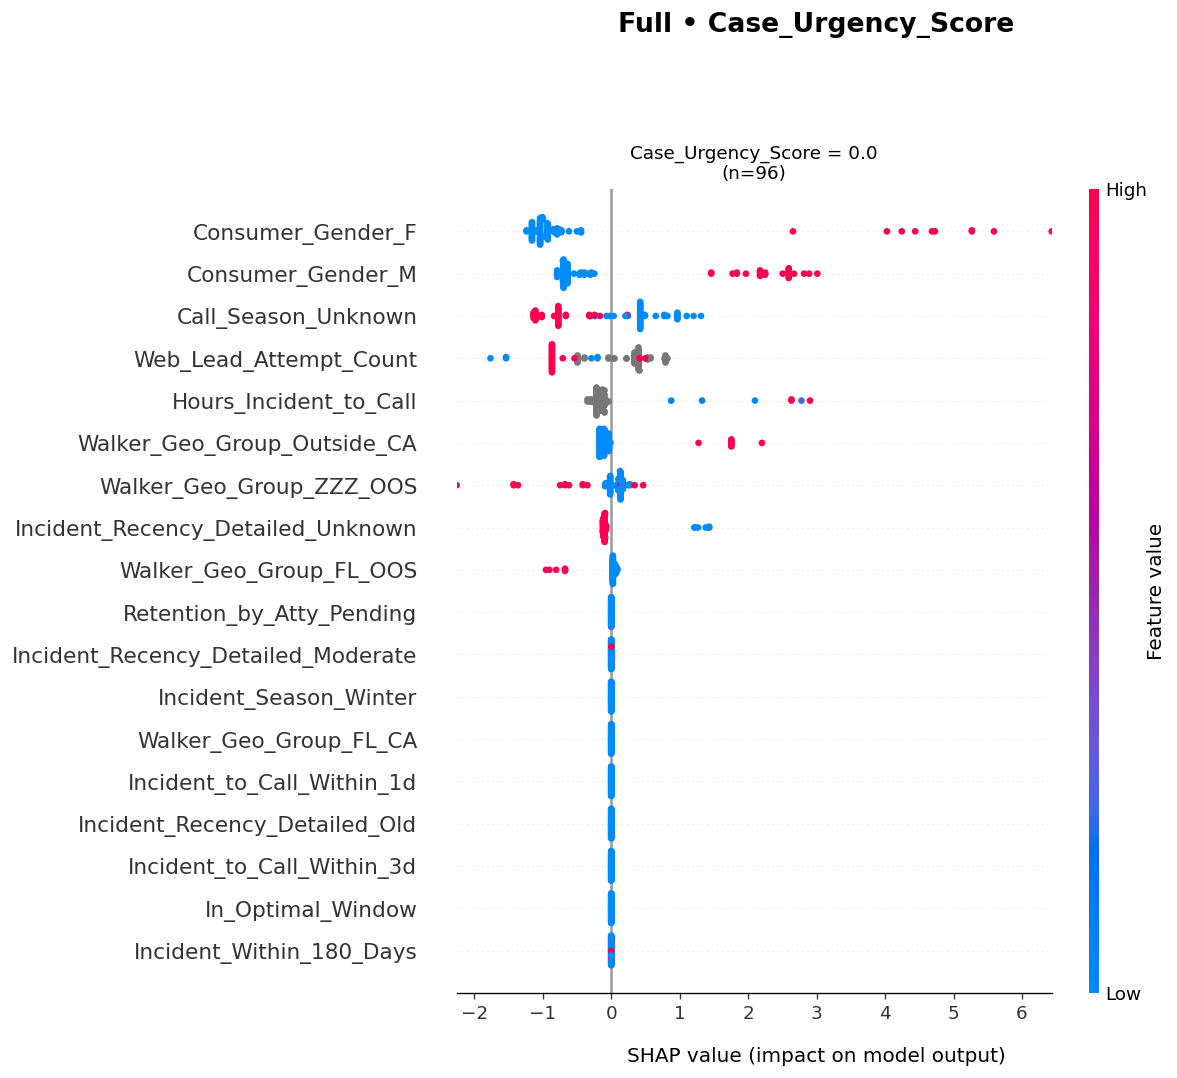

✅ Saved side-by-side figure (anchor excluded): multivariate_modeling_results\shap_zoom\Full\Full_Case_Urgency_Score_ALL_BUCKETS_side_by_side.png


c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning:

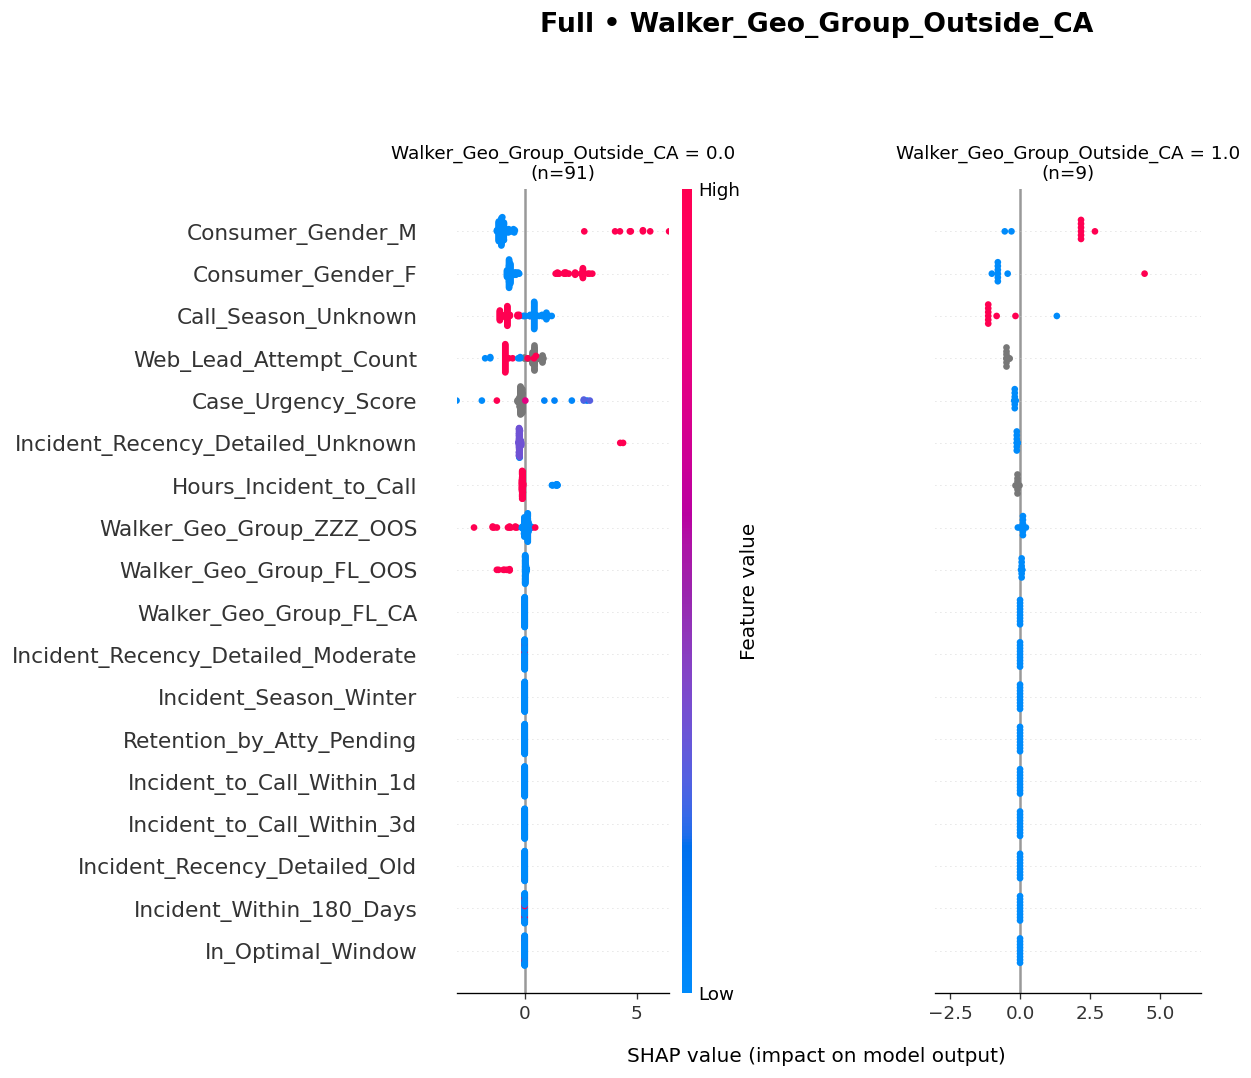

✅ Saved side-by-side figure (anchor excluded): multivariate_modeling_results\shap_zoom\Full\Full_Walker_Geo_Group_Outside_CA_ALL_BUCKETS_side_by_side.png


c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning:

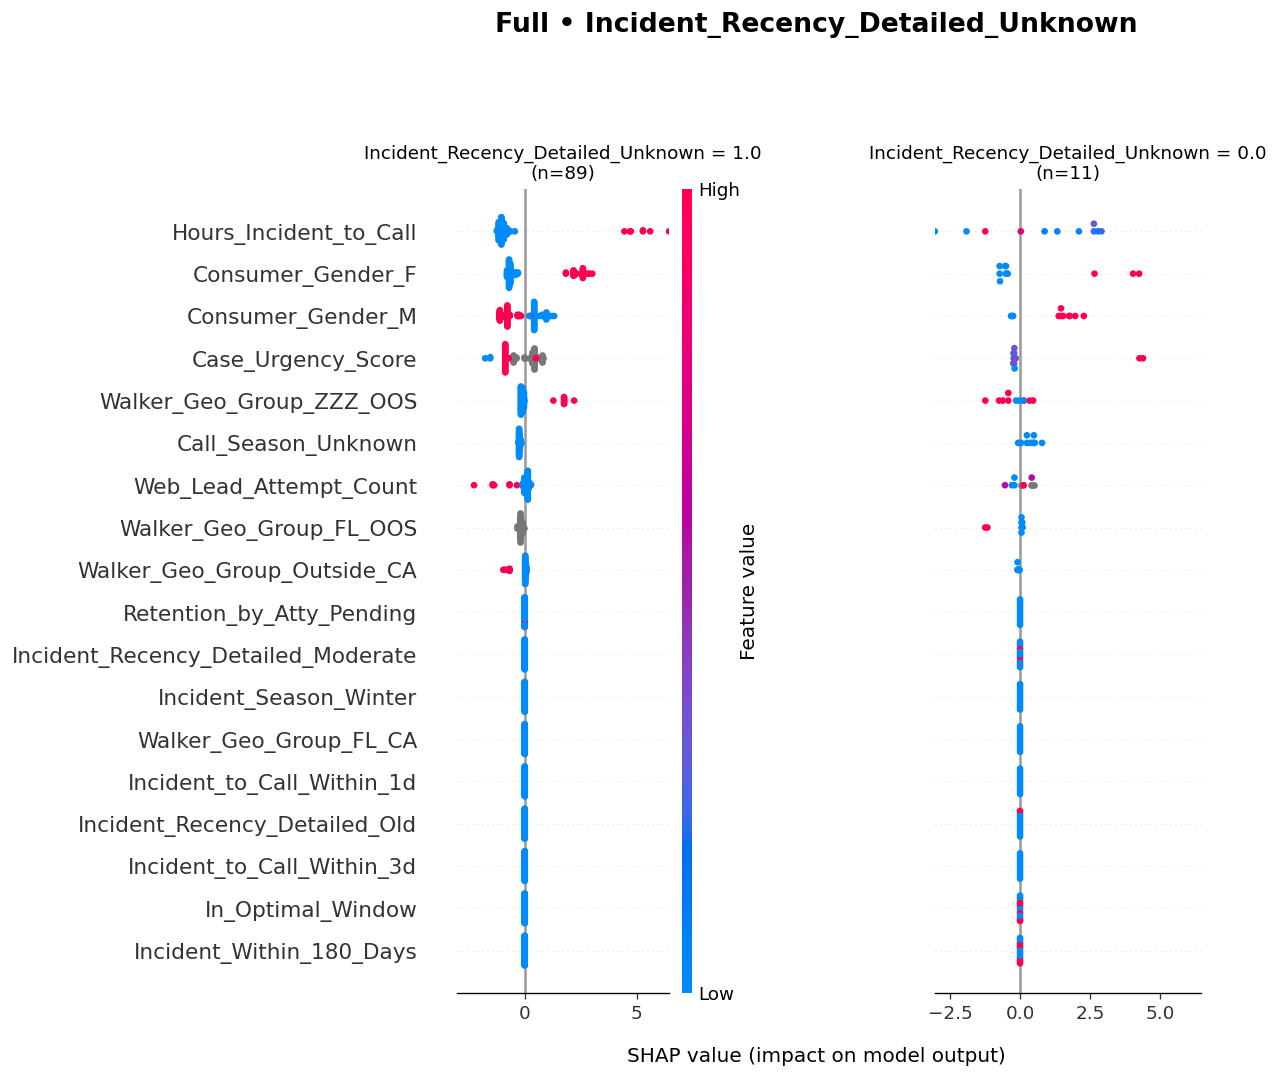

✅ Saved side-by-side figure (anchor excluded): multivariate_modeling_results\shap_zoom\Full\Full_Incident_Recency_Detailed_Unknown_ALL_BUCKETS_side_by_side.png


c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


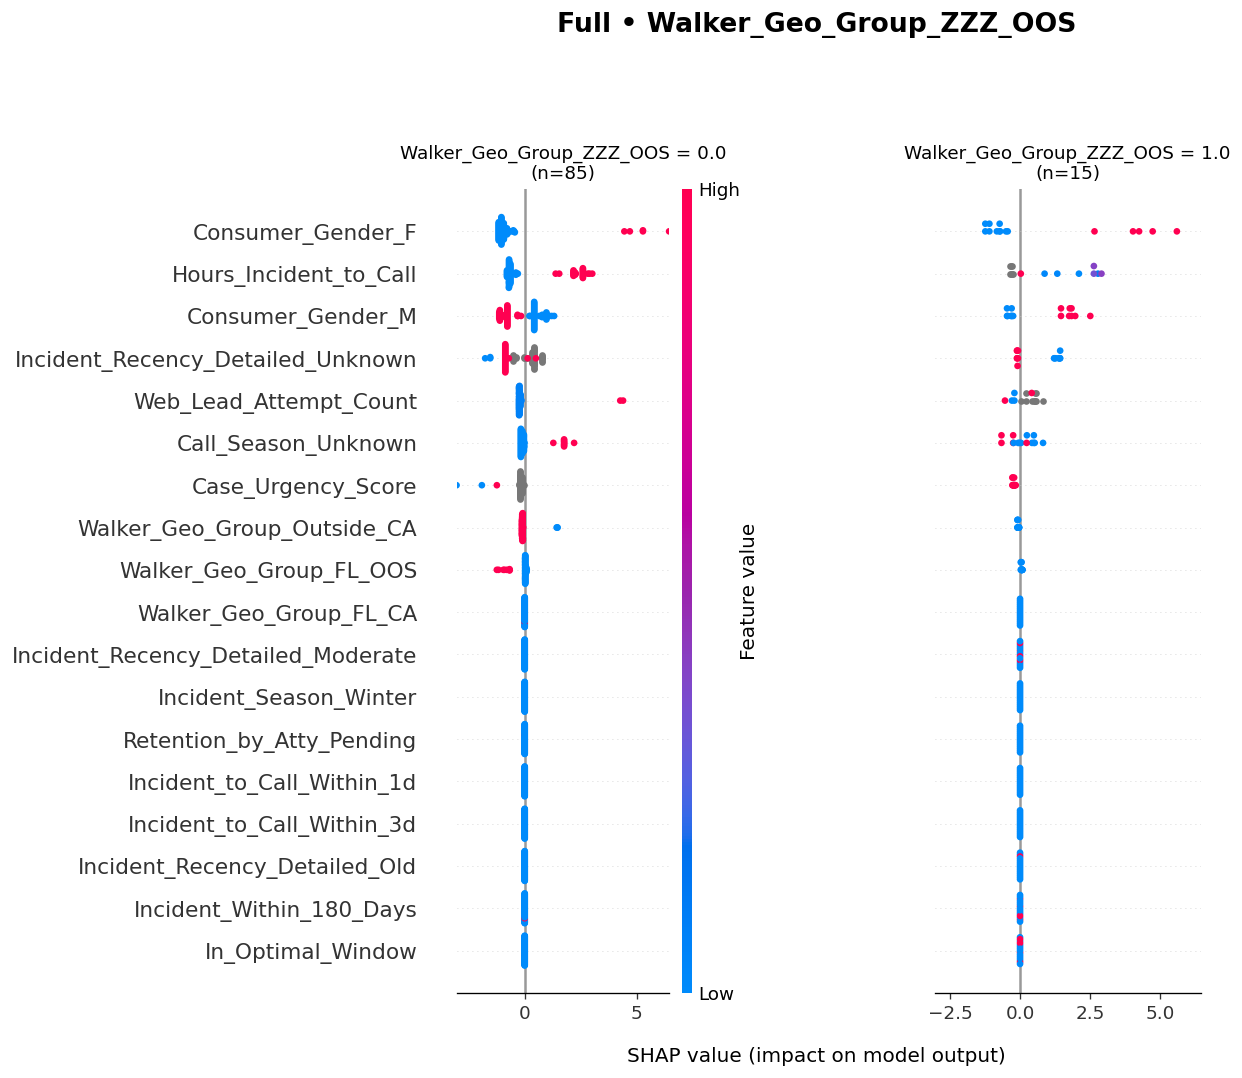

✅ Saved side-by-side figure (anchor excluded): multivariate_modeling_results\shap_zoom\Full\Full_Walker_Geo_Group_ZZZ_OOS_ALL_BUCKETS_side_by_side.png


c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


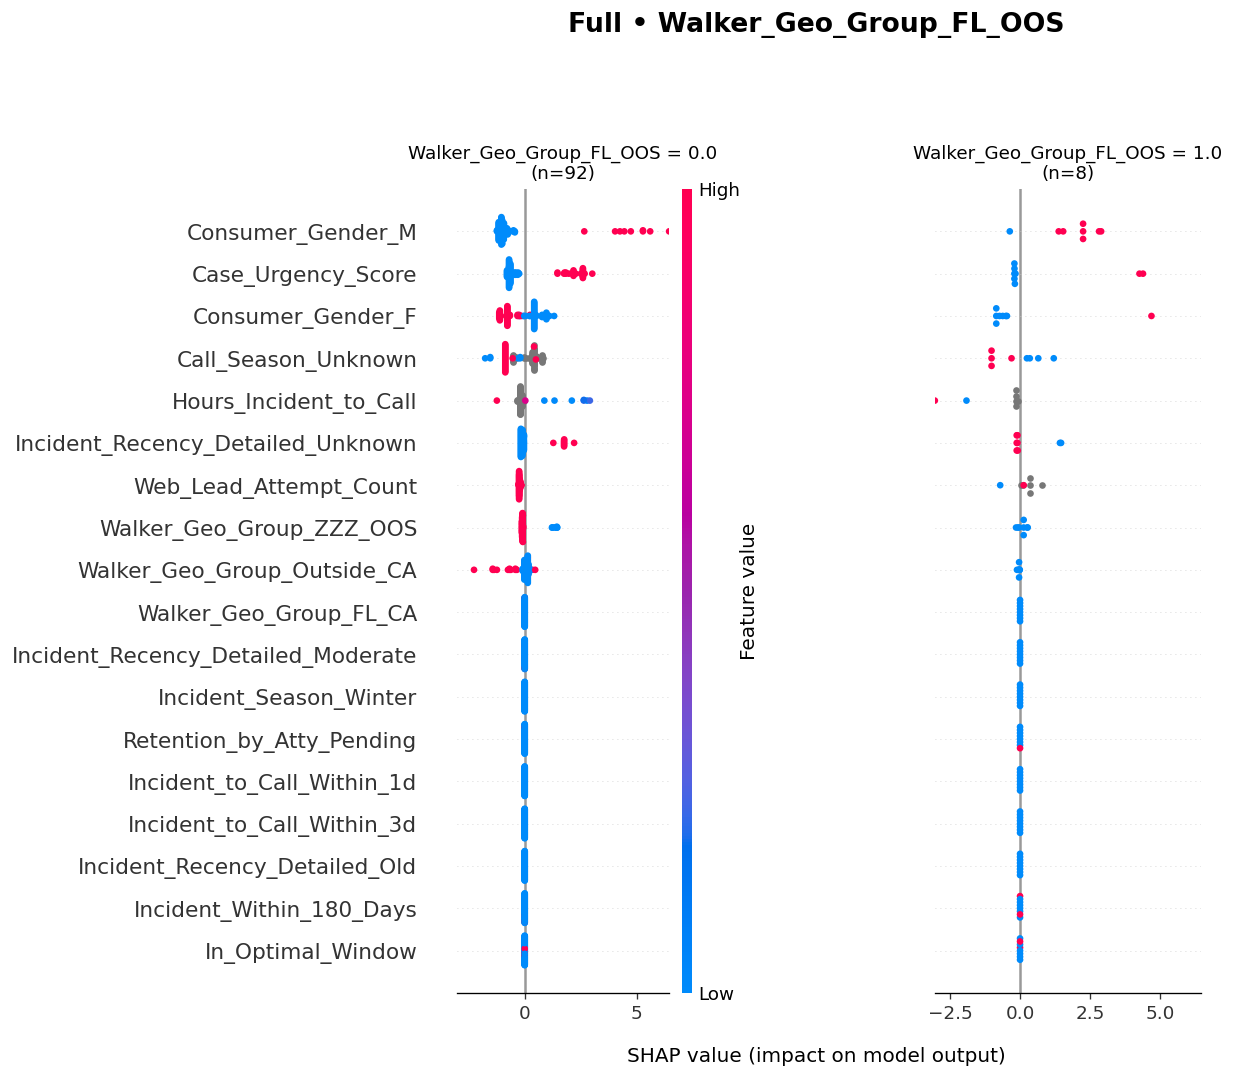

✅ Saved side-by-side figure (anchor excluded): multivariate_modeling_results\shap_zoom\Full\Full_Walker_Geo_Group_FL_OOS_ALL_BUCKETS_side_by_side.png


c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


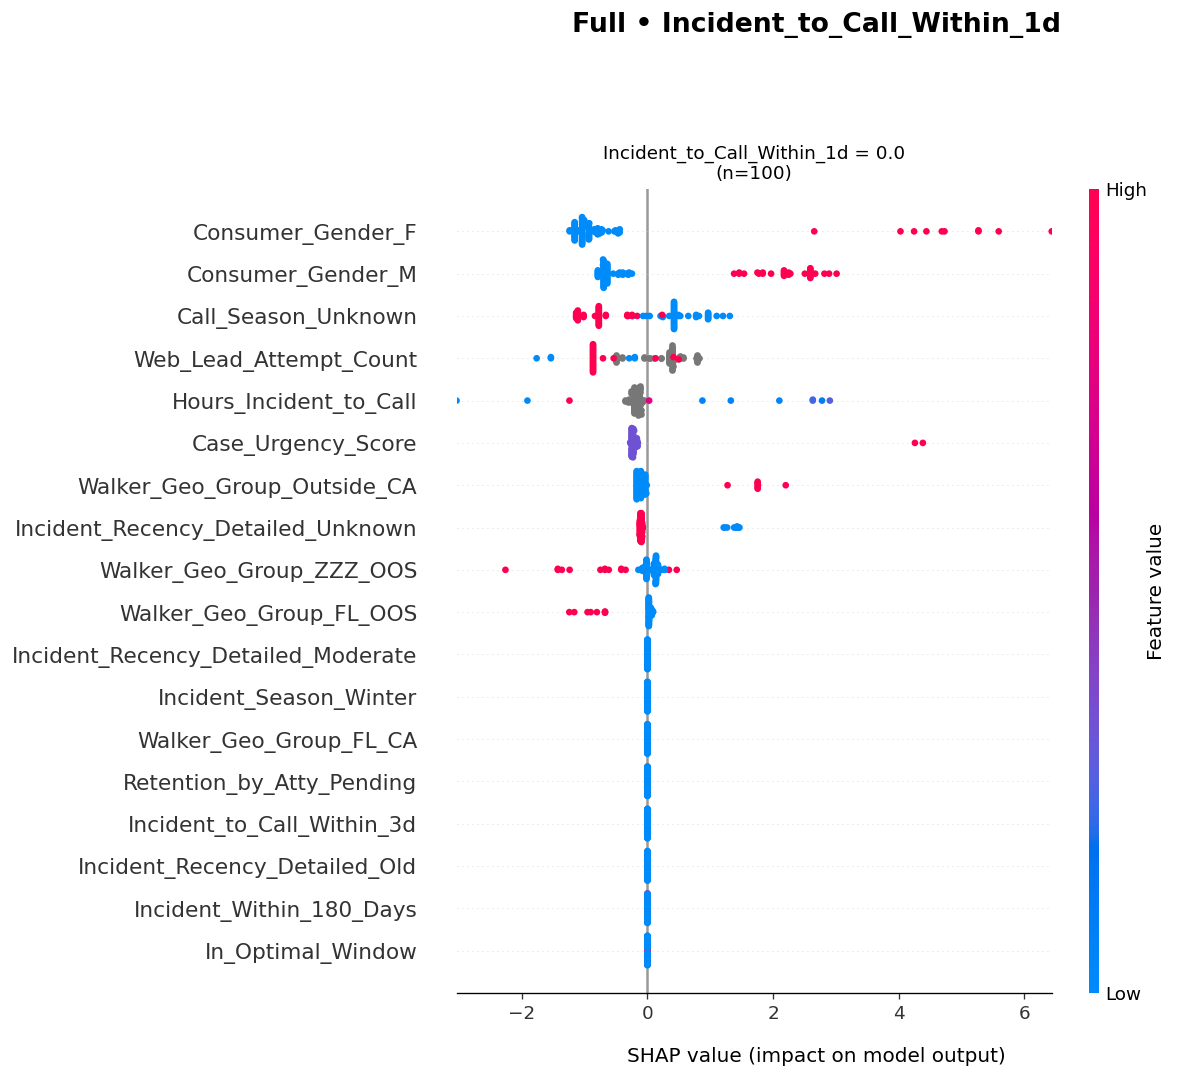

✅ Saved side-by-side figure (anchor excluded): multivariate_modeling_results\shap_zoom\Full\Full_Incident_to_Call_Within_1d_ALL_BUCKETS_side_by_side.png


c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


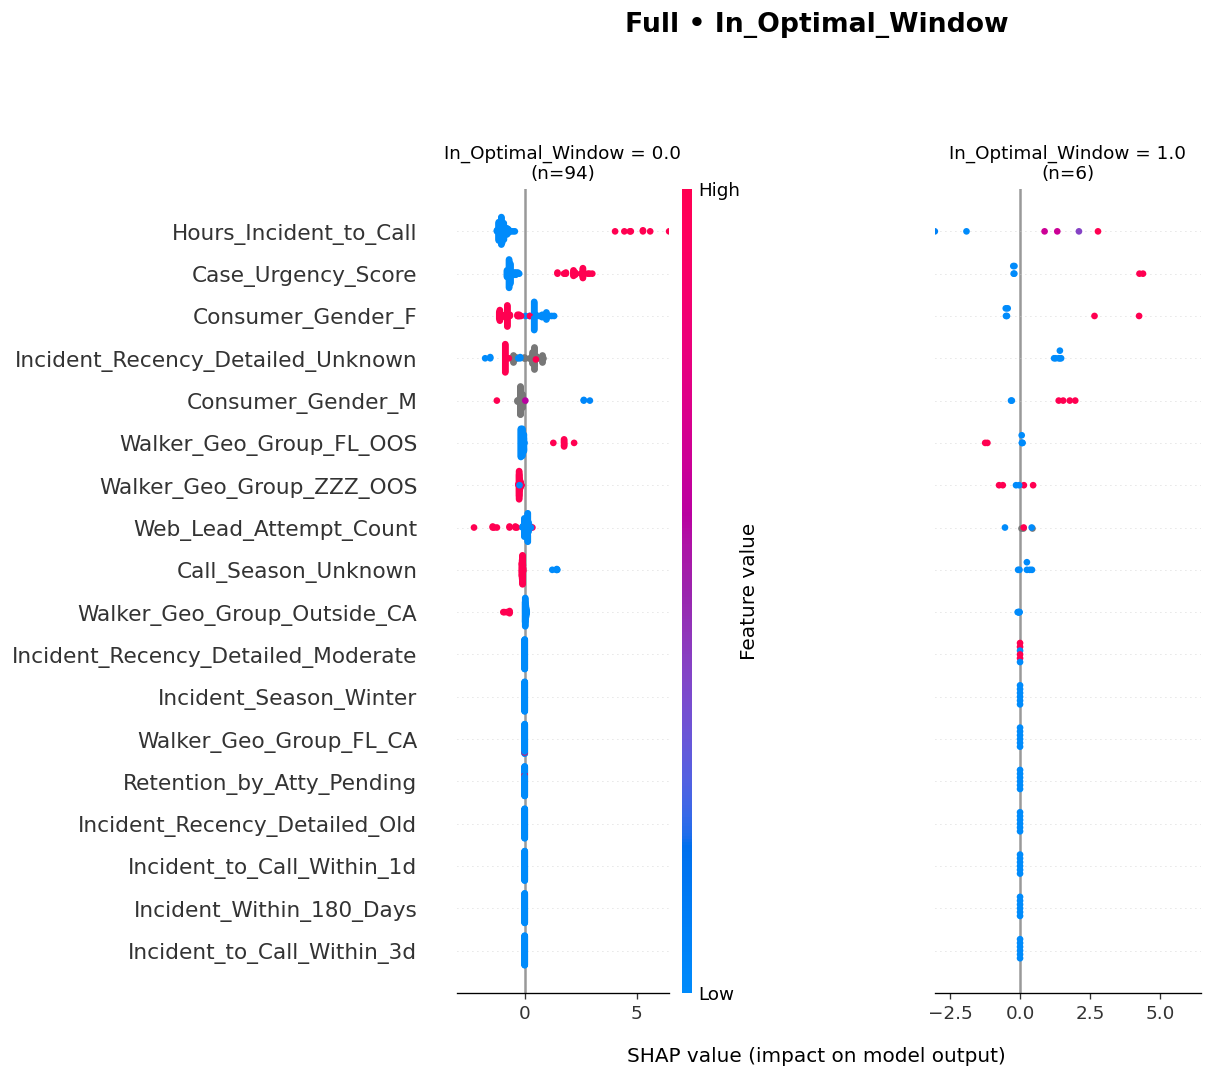

✅ Saved side-by-side figure (anchor excluded): multivariate_modeling_results\shap_zoom\Full\Full_In_Optimal_Window_ALL_BUCKETS_side_by_side.png


c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


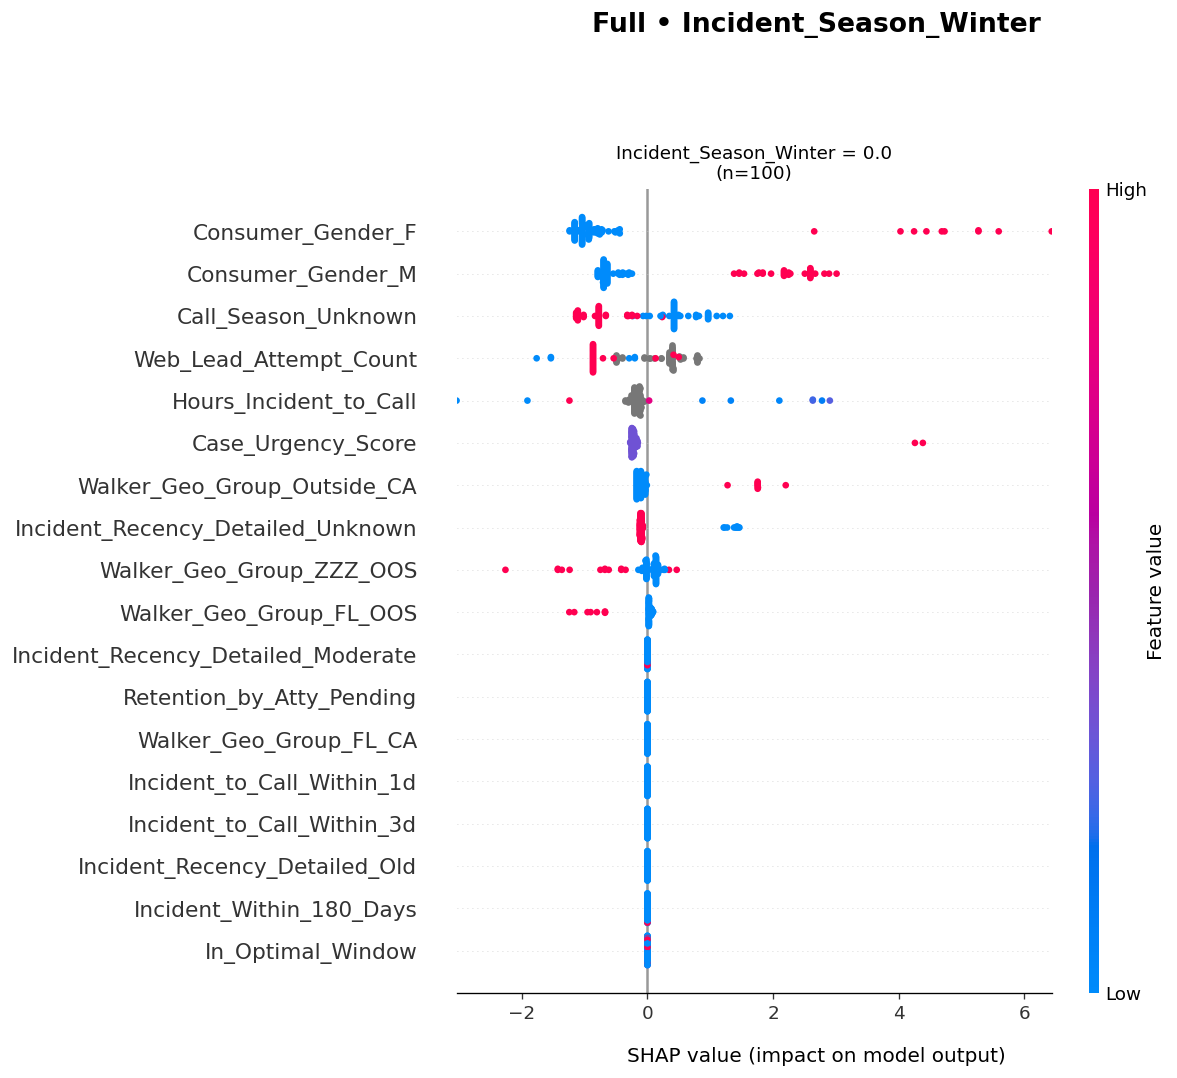

✅ Saved side-by-side figure (anchor excluded): multivariate_modeling_results\shap_zoom\Full\Full_Incident_Season_Winter_ALL_BUCKETS_side_by_side.png
⚠️ Skipping slice 'Incident_Recency_Detailed_Old = 1.0' for Incident_Recency_Detailed_Old: n=1 < 5


c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


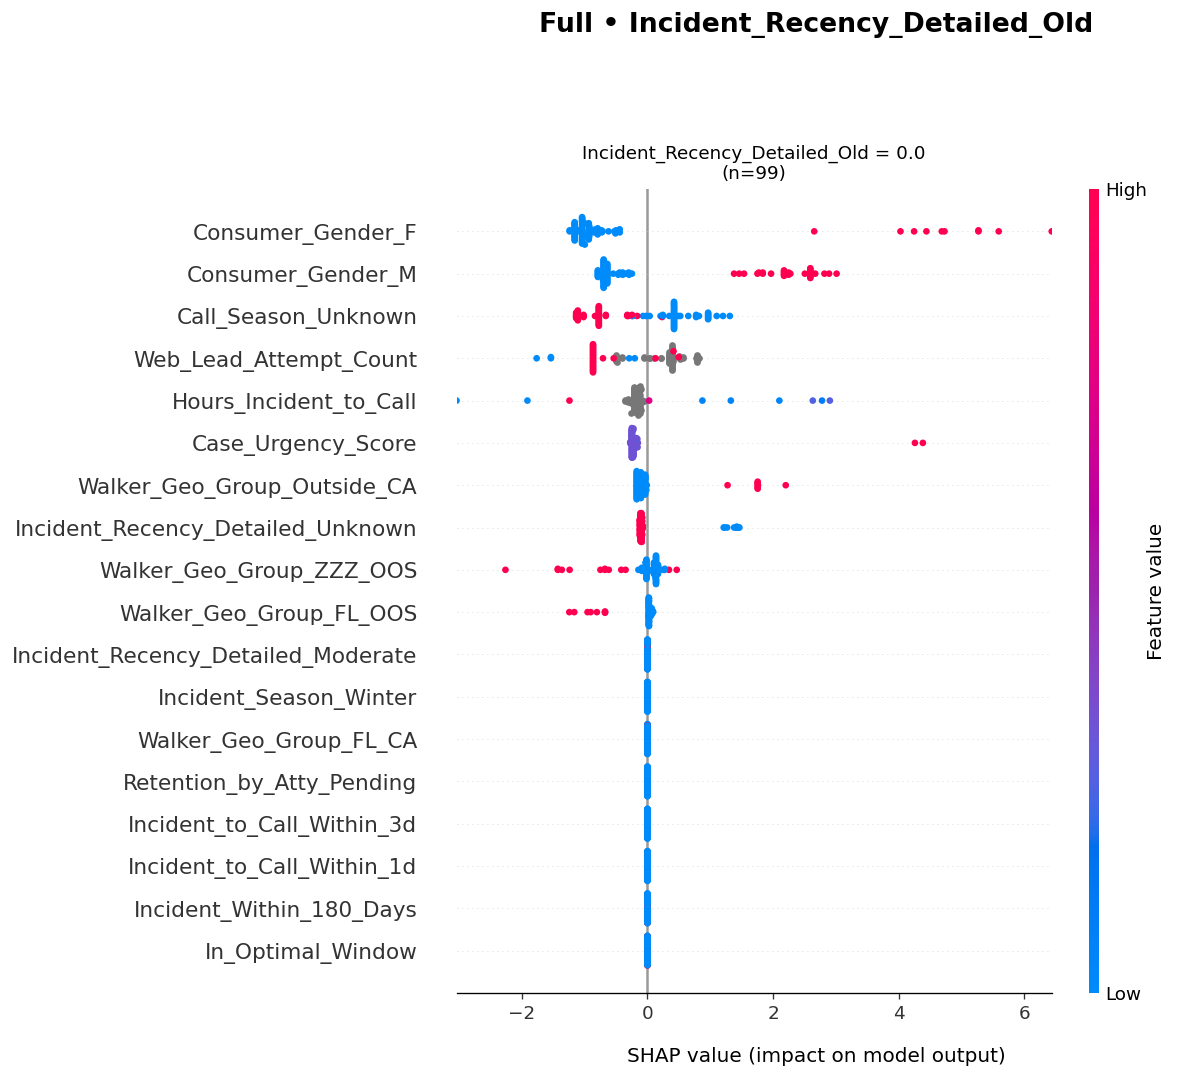

✅ Saved side-by-side figure (anchor excluded): multivariate_modeling_results\shap_zoom\Full\Full_Incident_Recency_Detailed_Old_ALL_BUCKETS_side_by_side.png


c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


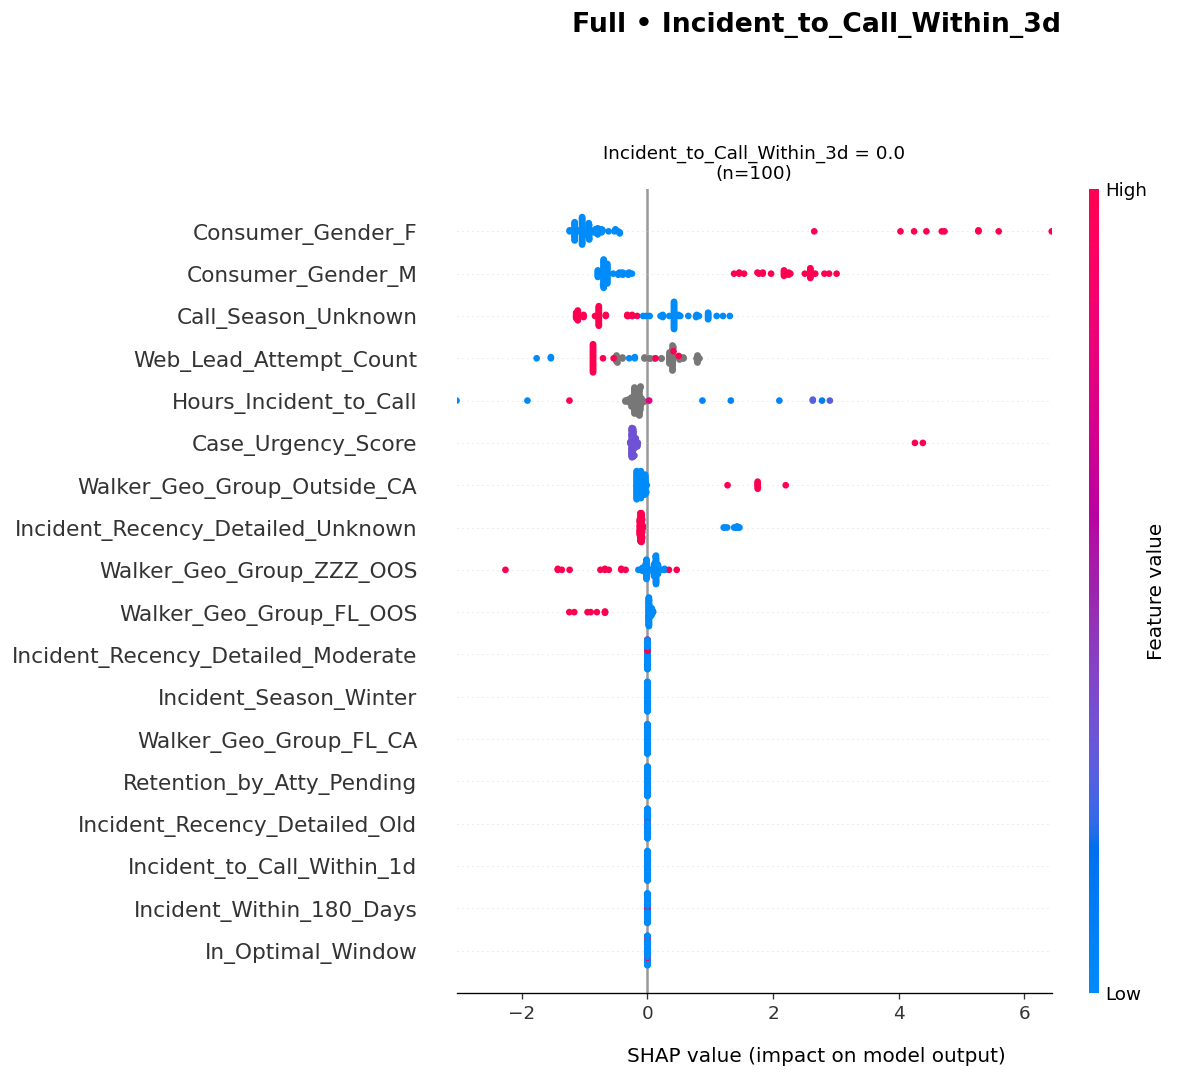

✅ Saved side-by-side figure (anchor excluded): multivariate_modeling_results\shap_zoom\Full\Full_Incident_to_Call_Within_3d_ALL_BUCKETS_side_by_side.png


c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


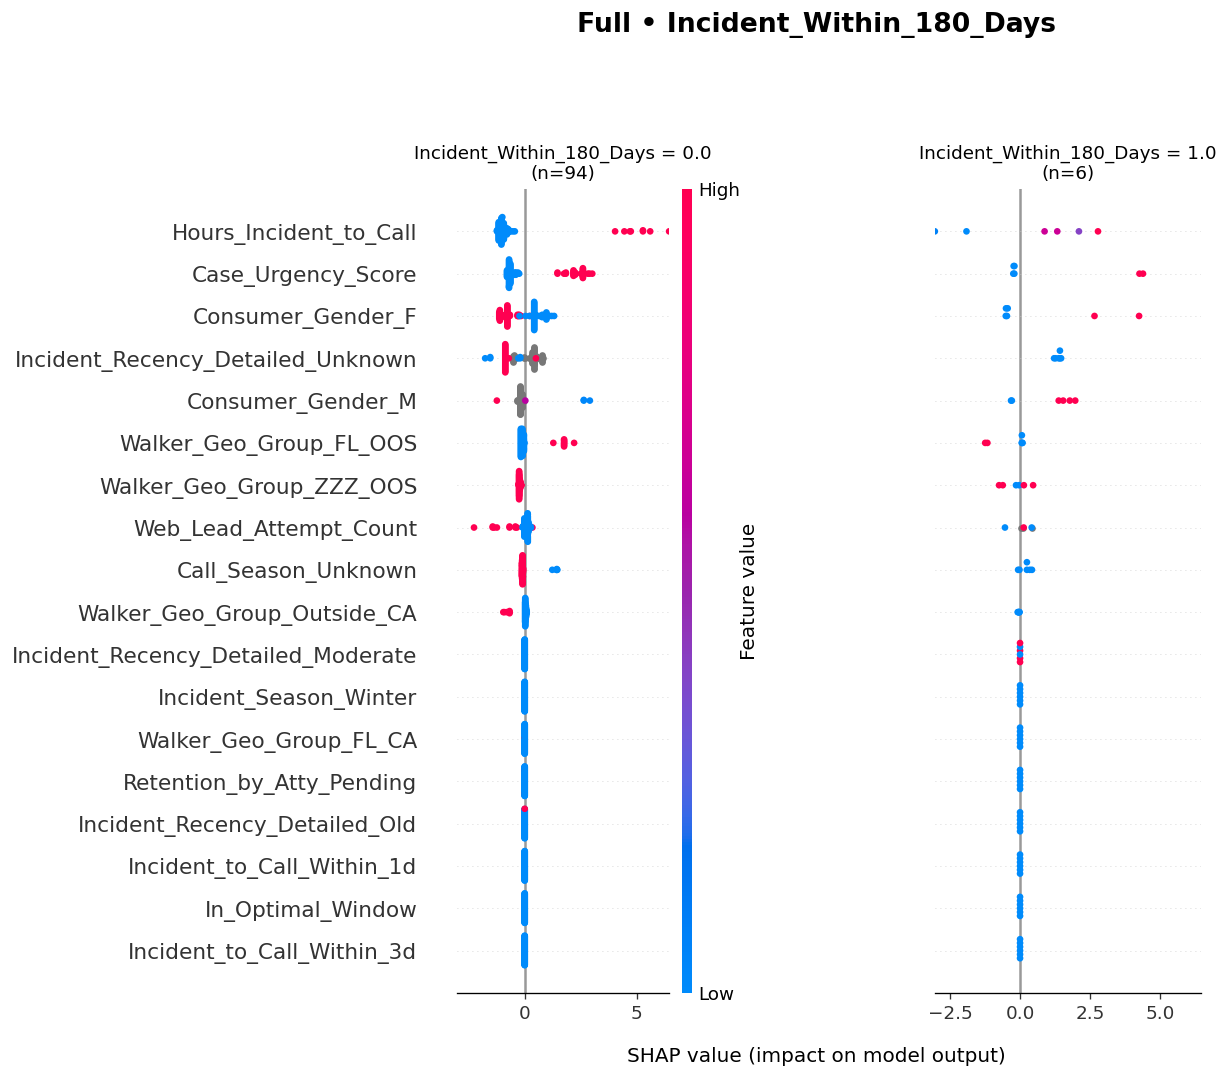

✅ Saved side-by-side figure (anchor excluded): multivariate_modeling_results\shap_zoom\Full\Full_Incident_Within_180_Days_ALL_BUCKETS_side_by_side.png
⚠️ Skipping slice 'Walker_Geo_Group_FL_CA = 1.0' for Walker_Geo_Group_FL_CA: n=1 < 5


c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


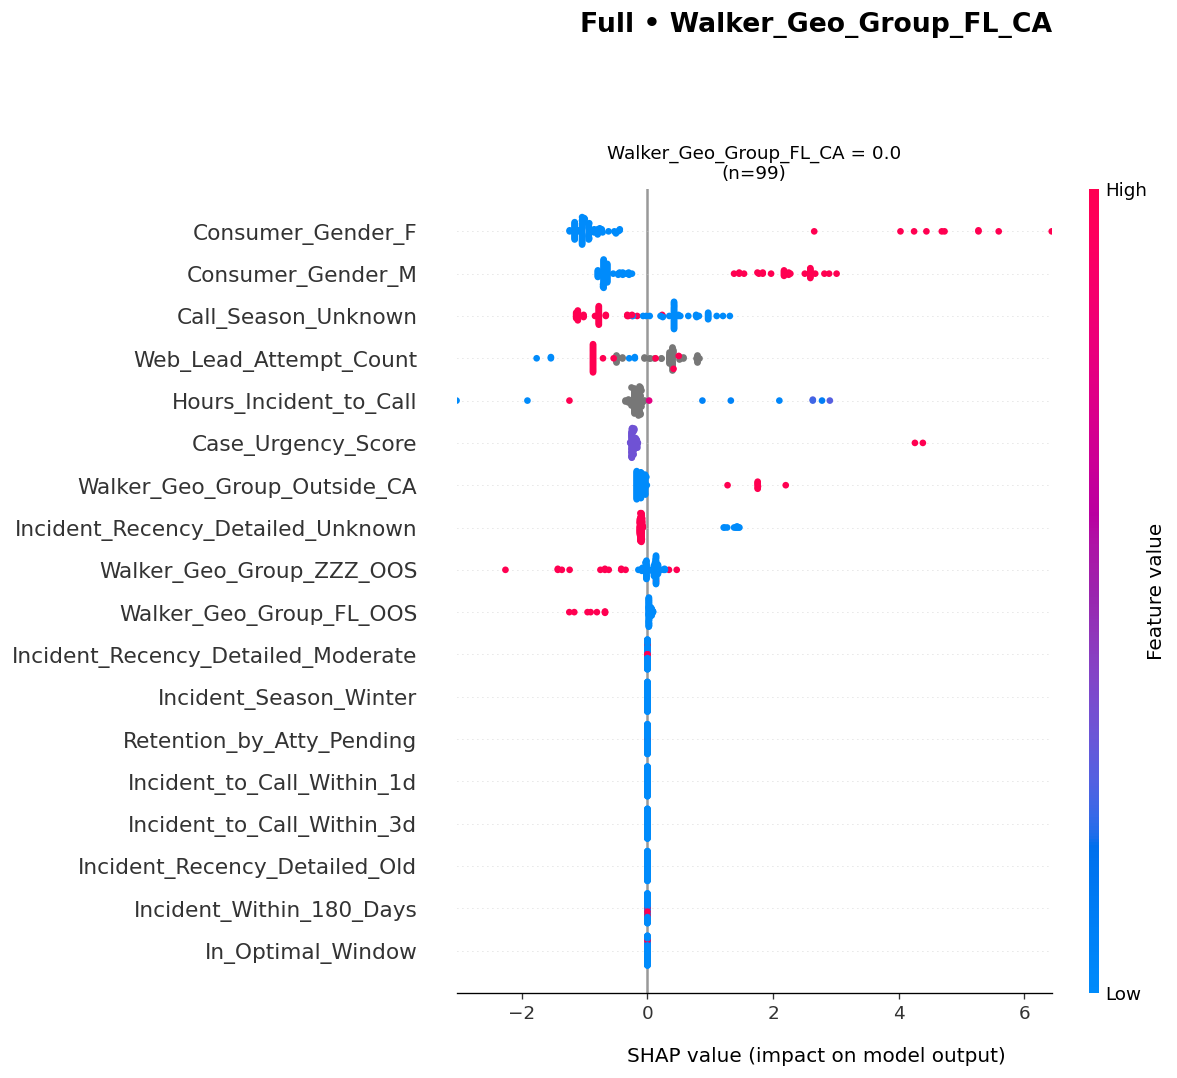

✅ Saved side-by-side figure (anchor excluded): multivariate_modeling_results\shap_zoom\Full\Full_Walker_Geo_Group_FL_CA_ALL_BUCKETS_side_by_side.png
⚠️ Skipping slice 'Retention_by_Atty_Pending = 1.0' for Retention_by_Atty_Pending: n=2 < 5


c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


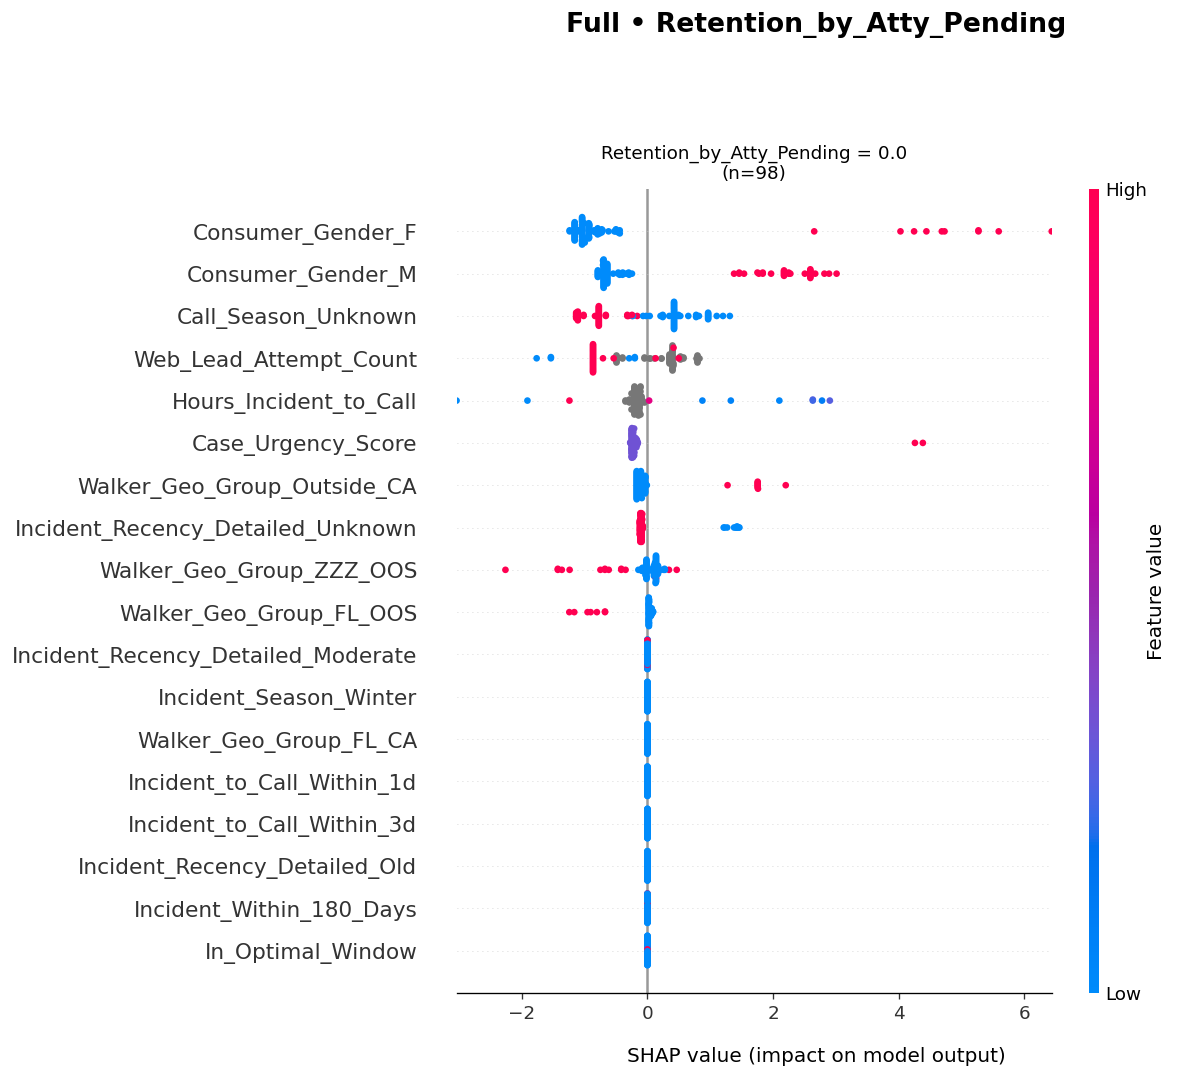

✅ Saved side-by-side figure (anchor excluded): multivariate_modeling_results\shap_zoom\Full\Full_Retention_by_Atty_Pending_ALL_BUCKETS_side_by_side.png
⚠️ Skipping slice 'Incident_Recency_Detailed_Moderate = 1.0' for Incident_Recency_Detailed_Moderate: n=4 < 5


c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
c:\Users\macar\AppData\Local\Programs\Python\Python313\Lib\site-packages\shap\plots\_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


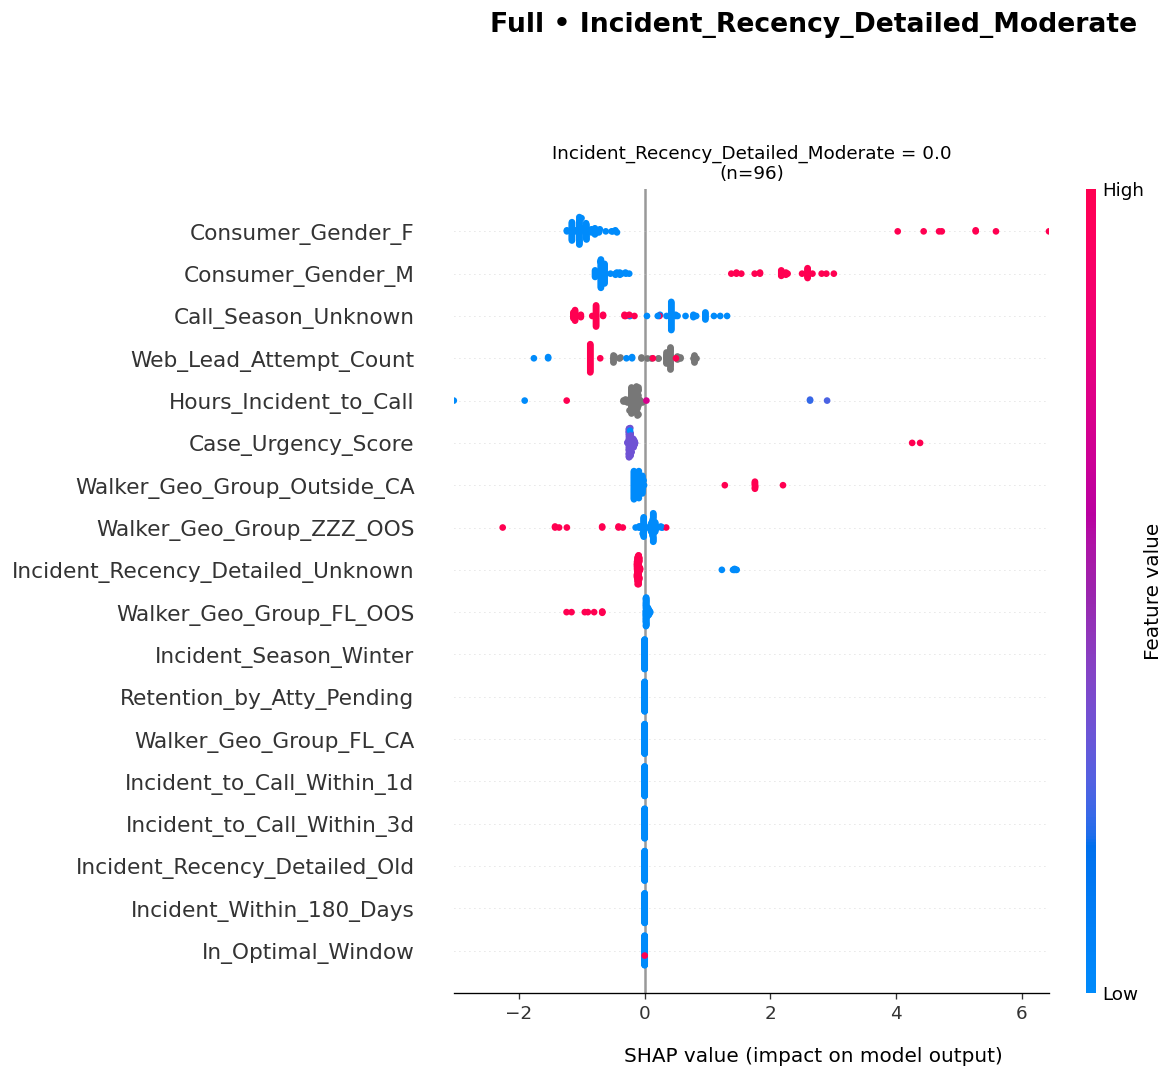

✅ Saved side-by-side figure (anchor excluded): multivariate_modeling_results\shap_zoom\Full\Full_Incident_Recency_Detailed_Moderate_ALL_BUCKETS_side_by_side.png


In [8]:
# === Cell Block: SHAP "Zoom" on top features from Insights.xlsx (side-by-side, anchor excluded) ===
import os
import re
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- Compat patch for SHAP on NumPy >=1.24 ---
if not hasattr(np, "bool"):
    np.bool = np.bool_

# ---- Config ----
INSIGHTS_XLSX    = "Insights.xlsx"   # workbook path (same dir as notebook)
MONTH_SHEET      = str(month)        # "January", "May", "Full", etc.
TOP_K_FEATURES   = 30                # how many top features to zoom on
MAX_DISPLAY      = 30                # beeswarm feature cap within each subplot
MIN_SLICE_ROWS   = 5                 # skip tiny slices
EXCLUDE_ANCHOR_FROM_PANELS = True    # hide the zoomed feature from each beeswarm

# ---- Display / export sizing ----
SUBPLOT_WIDTH_IN  = 6     # width per subplot (inches)
SUBPLOT_HEIGHT_IN = 6     # figure height (inches)
PREVIEW_DPI       = 120   # notebook/VSCode render DPI
SAVE_DPI          = 300   # PNG export DPI (pixels = inches * DPI)

mpl.rcParams["figure.dpi"]  = PREVIEW_DPI
mpl.rcParams["savefig.dpi"] = SAVE_DPI

# Output directory: multivariate_modeling_results/shap_zoom/<MONTH>
safe_month = re.sub(r"[^\w\-.]+", "_", MONTH_SHEET)
outdir = os.path.join("multivariate_modeling_results", "shap_zoom", safe_month)
os.makedirs(outdir, exist_ok=True)

# Reuse the trained model; build (or reuse) an explainer
try:
    explainer
except NameError:
    explainer = shap.TreeExplainer(model)

# --- Helpers ------------------------------------------------------------
def _find_col(df, targets):
    """Find a column by name robustly (case/punctuation/underscores)."""
    norm = lambda s: re.sub(r"[^a-z0-9]+", "", str(s).lower())
    cols_norm = {norm(c): c for c in df.columns}
    for t in targets:
        t_norm = norm(t)
        if t_norm in cols_norm:
            return cols_norm[t_norm]
    for t in targets:
        t_norm = re.sub(r"[^a-z0-9]+", "", t.lower())
        for c in df.columns:
            if t_norm in re.sub(r"[^a-z0-9]+", "", c.lower()):
                return c
    return None

def _guess_unit(feat_name: str):
    n = feat_name.lower()
    if "day" in n:   return "days"
    if "hour" in n:  return "hours"
    if "week" in n:  return "weeks"
    if "month" in n: return "months"
    return None

def _fmt_edge(val, unit=None):
    if np.isneginf(val): s = "−∞"
    elif np.isposinf(val): s = "+∞"
    else:
        s = f"{int(round(val))}" if abs(val - round(val)) < 1e-6 else f"{val:.2f}"
    return f"{s} {unit}" if (unit and np.isfinite(val)) else s

def get_top_features_from_insights(xlsx_path, sheet, top_k=3):
    """
    Return top_k features using rank_by_mean_abs_shap (ascending).
    Fallbacks: mean_abs_shap (desc), then generic 'rank' (asc), then first N rows.
    """
    ins = pd.read_excel(xlsx_path, sheet_name=sheet)
    feat_col = _find_col(ins, ["feature"])
    if feat_col is None:
        raise ValueError(f"Couldn't find a Feature column in sheet '{sheet}' of {xlsx_path}.")

    rank_col = _find_col(ins, ["rank_by_mean_abs_shap"])
    if rank_col:
        top = (ins[[feat_col, rank_col]]
               .dropna(subset=[feat_col])
               .sort_values(rank_col, ascending=True)[feat_col]
               .head(top_k).tolist())
    else:
        mean_col = _find_col(ins, ["mean_abs_shap"])
        if mean_col:
            top = (ins[[feat_col, mean_col]]
                   .dropna(subset=[feat_col])
                   .sort_values(mean_col, ascending=False)[feat_col]
                   .head(top_k).tolist())
        else:
            any_rank = _find_col(ins, ["rank"])
            if any_rank:
                top = (ins[[feat_col, any_rank]]
                       .dropna(subset=[feat_col])
                       .sort_values(any_rank, ascending=True)[feat_col]
                       .head(top_k).tolist())
            else:
                top = ins[feat_col].dropna().head(top_k).tolist()

    top = [t for t in top if t in X_val.columns]
    print(f"🔝 Using rank-based top features for {sheet}: {top}")
    return top

def make_numeric_std_buckets(s: pd.Series, feat_name: str, allow_negative: bool = False):
    """
    Build 4 buckets from mean±SD but keep labels human-friendly and
    avoid negatives when the data are non-negative (typical for hours/days).

    Rules
    -----
    - If s.min() >= 0 and allow_negative=False, clamp the lower edge to 0.
    - Always clamp internal edges to [min(s), max(s)] so we don't display crazy ranges.
    - Ensure strictly increasing edges; if distribution is degenerate, fall back to quantiles.
    - Labels become '0 to 12 hours', '12 to 24 hours', '24 to 36 hours', '36+ hours'
      (units inferred from the feature name when possible).
    """
    s = s.dropna()
    if s.empty:
        # fallback: return a single wide bucket that will be filtered by MIN_SLICE_ROWS anyway
        return [("All values", pd.Series([True]*len(s), index=s.index))]

    nonneg = (s.min() >= 0) and (not allow_negative)

    mu = float(s.mean())
    sd = float(s.std(ddof=0))
    # candidate edges from mean±sd
    edges = np.array([mu - sd, mu, mu + sd], dtype=float)

    # clamp edges to the observed range (and to 0 if nonneg)
    lo = 0.0 if nonneg else float(s.min())
    hi = float(s.max())
    edges = np.clip(edges, lo, hi)

    # build full edge list [lo, e1, e2, e3, +inf] and make strictly increasing
    full = np.array([lo, *edges.tolist(), np.inf], dtype=float)

    # If edges collapsed (e.g., sd≈0 or heavy skew), fall back to quantiles
    if not np.all(np.diff(np.minimum(full, hi + 1e-12)) > 0):
        q = s.quantile([0.0, 1/3, 2/3, 1.0]).to_numpy()
        full = np.array([0.0 if nonneg else q[0], q[1], q[2], q[3], np.inf], dtype=float)

    unit = _guess_unit(feat_name)

    def _fmt_edge(val):
        # pretty text (no negatives if nonneg=True because lo>=0)
        if np.isposinf(val):
            return "+∞"
        # integer-like formatting when close to an int
        return f"{int(round(val))}" if abs(val - round(val)) < 1e-6 else f"{val:.2f}"

    masks = []
    # create 4 bins: [full[0],full[1]] , (full[1],full[2]] , (full[2],full[3]] , (full[3],∞)
    for i in range(4):
        left, right = full[i], full[i+1]
        if i == 0:
            mask = s <= right
            left_txt = ("0" if nonneg else _fmt_edge(left))
            label = f"{left_txt} to {_fmt_edge(right)}"
        elif i == 3:
            mask = (s > left) & (s <= right)
            label = f"{_fmt_edge(left)}+"
        else:
            mask = (s > left) & (s <= right)
            label = f"{_fmt_edge(left)} to {_fmt_edge(right)}"

        # add units to finite numbers
        if unit:
            label = label.replace("+", f" {unit}+").replace(" to ", f" {unit} to ").replace("  ", " ")
            if " to +∞" in label:
                label = label.replace(" to +∞", f"{unit}+")

        masks.append((label, mask.reindex(X_val.index, fill_value=False)))
    return masks


def make_categorical_buckets(s: pd.Series, max_levels=4):
    """Up to 4 buckets by most frequent categories/values (good for binary like Is_Call_Back_Case)."""
    top_levels = s.value_counts(dropna=False).index.tolist()[:max_levels]
    return [(f"{s.name} = {val}", (s == val)) for val in top_levels]

def _select_positive_class_shap(shap_vals):
    """Return a 2D (n_samples, n_features) SHAP matrix."""
    if isinstance(shap_vals, list):
        try:
            pos_idx = list(getattr(model, "classes_", [])).index(1)
        except Exception:
            pos_idx = min(1, len(shap_vals)-1)
        return np.asarray(shap_vals[pos_idx])
    return np.asarray(shap_vals)

def _drop_anchor(arr: np.ndarray, X_df: pd.DataFrame, anchor: str):
    """Remove the anchor feature's column from SHAP array and X df (if present)."""
    if anchor in X_df.columns:
        idx = list(X_df.columns).index(anchor)
        arr_wo = np.delete(arr, idx, axis=1)
        X_wo = X_df.drop(columns=[anchor])
        return arr_wo, X_wo
    return arr, X_df

def shap_beeswarm_grid_for_feature(feat):
    """
    One image with N beeswarm subplots (side by side) for a single feature.
    - Excludes the anchor feature from each beeswarm if EXCLUDE_ANCHOR_FROM_PANELS=True
    - Unified SHAP x-axis, friendly titles, single colorbar on first panel
    - Saved under multivariate_modeling_results/shap_zoom/<MONTH>/
    """
    s = X_val[feat]
    # Bucketing
    if pd.api.types.is_numeric_dtype(s) and s.nunique(dropna=False) > 10:
        buckets = make_numeric_std_buckets(s, feat_name=feat)
    else:
        buckets = make_categorical_buckets(s, 4)

    # Valid slices
    slices = []
    for label, mask in buckets:
        X_slice = X_val.loc[mask]
        if len(X_slice) >= MIN_SLICE_ROWS:
            slices.append((label, X_slice))
        else:
            print(f"⚠️ Skipping slice '{label}' for {feat}: n={len(X_slice)} < {MIN_SLICE_ROWS}")
    if not slices:
        print(f"⚠️ No valid slices for {feat}; nothing to plot.")
        return

    # SHAP arrays + global x-lims (after optional anchor removal)
    shap_per_slice = []
    global_min, global_max = np.inf, -np.inf
    for _, X_slice in slices:
        arr = _select_positive_class_shap(explainer.shap_values(X_slice))
        if EXCLUDE_ANCHOR_FROM_PANELS:
            arr, X_slice = _drop_anchor(arr, X_slice, feat)
        shap_per_slice.append((arr, X_slice))
        if arr.size:
            global_min = min(global_min, float(np.nanmin(arr)))
            global_max = max(global_max, float(np.nanmax(arr)))

    n = len(slices)
    fig, axes = plt.subplots(
        1, n,
        figsize=(SUBPLOT_WIDTH_IN * n, SUBPLOT_HEIGHT_IN),
        sharey=True,
        dpi=PREVIEW_DPI,
        gridspec_kw={"wspace": 0.8}   # <--- add horizontal spacing
    )
    if n == 1:
        axes = [axes]

    for i, (ax, ((label, _), (arr, X_slice))) in enumerate(zip(axes, zip(slices, shap_per_slice))):
        plt.sca(ax)
        prev_axes = set(fig.axes)

        if arr.shape[1] == 0:
            ax.set_title(f"{label}\n(n={len(X_slice)})\n(no remaining features)", fontsize=11)
            ax.set_xlabel("")
            continue

        md = min(MAX_DISPLAY, arr.shape[1])
        shap.summary_plot(arr, X_slice, max_display=md, show=False, color_bar=(i == 0))

        # Remove extra colorbars on non-first panels if SHAP adds them
        if i > 0:
            for extra in [a for a in fig.axes if a not in prev_axes and a is not ax]:
                try: extra.remove()
                except: pass

        ax.set_title(f"{label}\n(n={len(X_slice)})", fontsize=11)
        if np.isfinite(global_min) and np.isfinite(global_max):
            ax.set_xlim(global_min, global_max)
        ax.set_xlabel("")

    # Main title high enough not to collide with subplot titles
    # ... after setting titles/xlabels but before saving
    fig.canvas.draw()  # make sure tight bbox knows about suptitle/supxlabel/colorbars
    fname = os.path.join(outdir, f"{MONTH_SHEET}_{feat}_ALL_BUCKETS_side_by_side.png").replace(" ", "_")

    # slightly lower the suptitle and raise the shared xlabel to guarantee room
    fig.suptitle(f"{MONTH_SHEET} • {feat}", y=1.05, fontsize=16, fontweight="bold")
    try:
        fig.supxlabel("SHAP value (impact on model output)", fontsize=12, y=0.04)
    except Exception:
        fig.text(0.5, 0.04, "SHAP value (impact on model output)", ha="center", va="center", fontsize=12)

    # save with a tight bounding box and a tiny pad
    fig.savefig(fname, dpi=SAVE_DPI, bbox_inches="tight", pad_inches=0.25)

    plt.show()
    plt.close(fig)
    print(f"✅ Saved side-by-side figure (anchor excluded): {fname}")

# --- Main: get top features and create one image per feature with subplots ----
top_feats = get_top_features_from_insights(INSIGHTS_XLSX, MONTH_SHEET, TOP_K_FEATURES)
print(f"🔎 Top features for {MONTH_SHEET}: {top_feats}")

for feat in top_feats:
    shap_beeswarm_grid_for_feature(feat)


In [9]:
# === Export: Bucketed in-bucket SHAP stats for ALL features per zoom, to one mega sheet ===
import pandas as pd
import numpy as np
from pathlib import Path
from zipfile import BadZipFile
from openpyxl import load_workbook

ZOOM_XLSX = Path("Insights - Zoom - Marketing.xlsx").resolve()

def _sanitize_sheet_name(name: str) -> str:
    bad = set(':\\/?*[]')
    clean = ''.join(ch if ch not in bad else '-' for ch in name)
    return clean[:31] if len(clean) > 31 else clean

def _get_month_name():
    try:
        return str(month)
    except NameError:
        return "Full"

def _feature_rank_map(top_feats: list) -> dict:
    return {f: i+1 for i, f in enumerate(top_feats)}

def _safe_writer_mode(xlsx_path: Path) -> str:
    if not xlsx_path.exists():
        return "w"
    try:
        _ = load_workbook(xlsx_path)
        return "a"
    except (BadZipFile, KeyError, OSError, ValueError) as e:
        backup = xlsx_path.with_suffix(xlsx_path.suffix + ".bak")
        try:
            xlsx_path.replace(backup)
            print(f"⚠️ '{xlsx_path.name}' invalid ({type(e).__name__}); backed up to '{backup.name}', recreating.")
        except Exception:
            xlsx_path.unlink(missing_ok=True)
            print(f"⚠️ '{xlsx_path.name}' invalid, removed; recreating.")
        return "w"

def _build_S_df(shap_matrix, feature_names, index_like):
    """Return a DataFrame S (n_rows x n_features) aligned with X_for_shap index."""
    S = pd.DataFrame(np.asarray(shap_matrix), columns=feature_names)
    S.index = index_like
    return S

def compute_bucket_table_for_anchor(anchor: str, anchor_pos: int,
                                    S_full: pd.DataFrame,
                                    X_df: pd.DataFrame) -> pd.DataFrame:
    """
    For a given anchor feature:
      - make buckets on the anchor's *values*
      - for each bucket, compute SHAP stats for *all* features using only rows in that bucket
      - return tall table with anchor meta + per-feature stats
    """
    # Buckets based on anchor values
    s_vals = X_df[anchor]

    allow_negative = False
    try:
        if pd.api.types.is_numeric_dtype(s_vals):
            allow_negative = (s_vals.min() < 0)
    except Exception:
        pass

    slices = make_numeric_std_buckets(s_vals, feat_name=anchor, allow_negative=allow_negative)

    rows = []
    for (label, mask) in slices:
        idx_mask = mask if isinstance(mask, pd.Series) else pd.Series(mask, index=X_df.index)
        if not idx_mask.any():
            continue

        S_bucket = S_full.loc[idx_mask]  # SHAP values restricted to bucket rows
        n = int(S_bucket.shape[0])
        if n < MIN_SLICE_ROWS:
            continue

        # --- Per-feature SHAP stats (in-bucket) ---
        mean_abs = np.abs(S_bucket).mean(0)
        mean     = S_bucket.mean(0)
        std      = S_bucket.std(0, ddof=1)
        q25      = S_bucket.quantile(0.25, axis=0)
        q50      = S_bucket.quantile(0.50, axis=0)
        q75      = S_bucket.quantile(0.75, axis=0)
        vmin     = S_bucket.min(0)
        vmax     = S_bucket.max(0)
        pct_pos  = (S_bucket > 0).mean(0)  # consistency of positive push

        # Exclude the anchor from the per-bucket table (reuse global flag)
        EXCLUDE_ANCHOR_FROM_TABLE = globals().get("EXCLUDE_ANCHOR_FROM_PANELS", True)
        if EXCLUDE_ANCHOR_FROM_TABLE and anchor in mean_abs.index:
            for s in [mean_abs, mean, std, q25, q50, q75, vmin, vmax, pct_pos]:
                s.drop(anchor, inplace=True, errors="ignore")

        if mean_abs.empty:
            continue

        # Rank within bucket so 1 = largest mean_abs_shap
        rank_in_bucket = mean_abs.rank(ascending=False, method="first").astype(int)

        # ---------- ROBUST DIRECTION ----------
        IQR = (q75 - q25)
        eps = np.maximum(1e-9, 0.05 * IQR.replace(0, np.nan).fillna(std * 0.05).fillna(1e-9))
        # standard error; guard std==0
        se  = std / np.sqrt(n)
        se  = se.replace(0, np.inf)
        t   = mean / se

        # start Mixed, then apply rules in priority order
        direction = pd.Series("Mixed", index=mean.index, dtype=object)

        # 1) Quantile override
        direction = direction.mask(q25 > eps, "Up")
        direction = direction.mask(q75 < -eps, "Down")

        # 2) Evidence fallback for remaining
        rem = direction.eq("Mixed")
        direction = direction.mask(rem & (mean.abs() <= eps), "Neutral")
        rem = direction.eq("Mixed")
        direction = direction.mask(rem & (mean > eps)  & ((t >= 2) | (pct_pos >= 0.60)), "Up")
        direction = direction.mask(rem & (mean < -eps) & ((t <= -2) | (pct_pos <= 0.40)), "Down")
        # anything still Mixed stays Mixed

        df_bucket = pd.DataFrame({
            "feature": mean_abs.index,
            "rank_by_mean_abs_shap_in_bucket": rank_in_bucket.loc[mean_abs.index].values,
            "mean_abs_shap": mean_abs.values,
            "mean_shap": mean.values,
            "std_shap": std.values,
            "min_shap": vmin.values,
            "p25_shap": q25.values,
            "p50_shap": q50.values,
            "p75_shap": q75.values,
            "max_shap": vmax.values,
            "n_rows": n,
            "pct_positive_shap_in_bucket": pct_pos.loc[mean_abs.index].values,
            "direction": direction.loc[mean_abs.index].values
        })


        # Attach anchor meta
        df_bucket.insert(0, "Zoomed In Feature", anchor)
        df_bucket.insert(1, "Zoomed In Feature Position", int(anchor_pos))
        df_bucket.insert(2, "bucket", str(label))

        rows.append(df_bucket)



    if not rows:
        return pd.DataFrame(columns=[
            "Zoomed In Feature","Zoomed In Feature Position","bucket",
            "feature","rank_by_mean_abs_shap_in_bucket","mean_abs_shap","mean_shap","std_shap",
            "min_shap","p25_shap","p50_shap","p75_shap","max_shap","n_rows"
        ])
    out = pd.concat(rows, ignore_index=True)

    # Nice ordering: by anchor position, then bucket (try to sort by numeric left edge), then rank within bucket
    import re
    def _bucket_sort_key(lbl):
        if pd.isna(lbl):
            return float("inf")
        m = re.search(r"([-+]?\d*\.?\d+)", str(lbl))
        return float(m.group(1)) if m else float("inf")

    out["__bucket_order__"] = out["bucket"].map(_bucket_sort_key)
    out = (out.sort_values(by=["Zoomed In Feature Position","__bucket_order__","rank_by_mean_abs_shap_in_bucket"],
                           kind="mergesort")
              .drop(columns="__bucket_order__")
              .reset_index(drop=True))
    return out

# ---- Drive the export (ONE mega sheet named exactly as your month string) ----
MONTH_NAME = _get_month_name()
SHEET_NAME = _sanitize_sheet_name(MONTH_NAME)

# Resolve feature names compatible with S matrix
if hasattr(X_for_shap, "columns"):
    feature_names = list(X_for_shap.columns)
else:
    try:
        feature_names = list(table["feature"])
    except Exception:
        raise RuntimeError("Could not resolve feature names for SHAP matrix.")

# Build S (full SHAP matrix) aligned to X_for_shap index
S_full = _build_S_df(shap_matrix, feature_names, X_for_shap.index)

# Top features to zoom and their 1-based positions
top_feats = get_top_features_from_insights(INSIGHTS_XLSX, MONTH_NAME, TOP_K_FEATURES)
pos_map = _feature_rank_map(top_feats)

# Build tall table for all anchors/buckets
tables = []
for anchor in top_feats:
    if anchor not in feature_names:
        continue
    anchor_pos = pos_map.get(anchor, None)
    if anchor_pos is None:
        continue
    tbl = compute_bucket_table_for_anchor(anchor, anchor_pos, S_full, X_for_shap)
    if not tbl.empty:
        tables.append(tbl)

if not tables:
    print(f"ℹ️ No bucket tables met MIN_SLICE_ROWS for '{MONTH_NAME}'. Skipping write to '{ZOOM_XLSX.name}'.")
else:
    df_all = pd.concat(tables, ignore_index=True)

    mode = _safe_writer_mode(ZOOM_XLSX)
    writer_kwargs = dict(engine="openpyxl", mode=mode)
    if mode == "a":
        writer_kwargs["if_sheet_exists"] = "replace"

    with pd.ExcelWriter(ZOOM_XLSX, **writer_kwargs) as writer:
        df_all.to_excel(writer, sheet_name=SHEET_NAME, index=False)

    print(f"✅ Wrote in-bucket SHAP stats for ALL features to '{ZOOM_XLSX.name}' (sheet: '{SHEET_NAME}'). "
          f"Rows: {len(df_all):,}; Anchors: {len(tables)}.")


🔝 Using rank-based top features for Full: ['Consumer_Gender_F', 'Consumer_Gender_M', 'Call_Season_Unknown', 'Web_Lead_Attempt_Count', 'Hours_Incident_to_Call', 'Case_Urgency_Score', 'Walker_Geo_Group_Outside_CA', 'Incident_Recency_Detailed_Unknown', 'Walker_Geo_Group_ZZZ_OOS', 'Walker_Geo_Group_FL_OOS', 'Incident_to_Call_Within_1d', 'In_Optimal_Window', 'Incident_Season_Winter', 'Incident_Recency_Detailed_Old', 'Incident_to_Call_Within_3d', 'Incident_Within_180_Days', 'Walker_Geo_Group_FL_CA', 'Retention_by_Atty_Pending', 'Incident_Recency_Detailed_Moderate']
✅ Wrote in-bucket SHAP stats for ALL features to 'Insights - Zoom - Marketing.xlsx' (sheet: 'Full'). Rows: 522; Anchors: 19.
